<font color='red'>Make sure you are using a dedicated virtual environment for Constellation.</font> For more info and to create one, see ds_measurement/setup.ipynb.


In [9]:
import sys  # using sys.executable forces installation in the active kernel
!{sys.executable} -m pip install --upgrade wfconstellation

Looking in indexes: https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/python/simple, https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/pypi-mirror/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wfconstellation
    Found existing installation: wfconstellation 0.3.41
    Uninstalling wfconstellation-0.3.41:
      Successfully uninstalled wfconstellation-0.3.41


In [10]:
from wfconstellation import gemini 
from wfconstellation.common_classes import TimeWindow
from wfconstellation.util import plot_comparisons
from wfconstellation.qa import QAConstellation

import numpy as np
import pandas as pd
import pandas_gbq
from datetime import date
from google.cloud import bigquery

In [11]:
import wfconstellation
print(wfconstellation.__version__)

0.3.43


## What's new in Gemini v7?

1. **Additional splitting algorithms that create more even groups:** There are 2 additional splitting options available, Palindromic v2 and Iterative Splitting, that decrease the relative difference of splits by up to 30% compared to the original method (developed with a former co-op on our team)
2. **Uneven splitting and stratified sampling options:** The additional algorithms  allow for uneven splits (e.g., 40/60 split) and a stratified sampling option (e.g., splitting units by class). The iterative splitting option can also allow for real-time splitting of units. 
3. **A/A power analysis feature** - Within eden-shared-nootebooks, there is a generalized A/A simulation function that allows users to understand the bias and minimum detectable lift for their tests 

## What is Gemini?

Gemini is an A/B testing framework designed for item-level tests (e.g., products, SKUs, URLs, classes) that creates 50/50 splits between groups and measures the treatment effect using a generalized estimating equation. Gemini has been used in tests for Paid Search (SEM-Intent, SEM-TOF, PLA), SEO, and Merch to measure treatment lifts for KPIs, such as visits, ATC, costs, revenue, and profit. To read more about the Gemini methodology, please see the [Infohub link](https://infohub.corp.wayfair.com/pages/viewpage.action?pageId=228066458) here. 

### **Design and Create Splits**

**Step 1: Create data table with 4 months of historical data** 
The first step in Gemini is to decide the units to randomize and the primary KPIs that need to be measured (up to 4-5 can be specified). To run the Gemini split, there must be at least 4 months of previous data for each unit and set of KPIs.  Gemini requires data at the daily level, so a table should be made containing daily KPI data for each unit that should be included in the test design. For example, if there are 100,000 units and 4 months of data, the table will be a maximum of 12M rows long (100,000 x 120 days), and there should be columns indicating the unit, date, and primary KPIs. It's easiest if these historical tables are produced and stored in GBQ.


**Step 2: Validate and Calibrate**
After creating the test splits, Gemini performs an A/A test using a generalized estimating equation (GEE) to ensure that there are no significant differences between groups during the validation period. The GEE model is used in the Measurement step as well (except data during the validation and test period will be used). 

Based on the parameters specified (e.g., quantile filter, number of subgroups), multiple designs can be run. Gemini will output the best design, depending on p-values and relative differences between groups. In general, we look to choose test splits that are relatively stable over the 4 months, appear equivalent during the training and validation period, and do not have large differences during peaks. 


### Step 1: Specify Design Parameters and Retrieve Test URL Table
#### **Important Notes about Gemini Designs**

1.   The input table must contain the final list of units that will be in the test! 
2.   It's recommended to generate a split 1-2 weeks before running the test. Gemini splits are usually stable for a maximum of 4-8 weeks.
3. This Python notebook assumes that there is a table in GBQ with units that will be used in the final test or that you will use a query to create a table. 
4. Design Level indicates which column you wish to design your test at. Gemini splits will be balanced across this Design Level. You also need to specify which level you will measure your results at. Often, the Design and Measurement level are the same. However, you can also design your test (e.g., at the class level) but measure at a different level (e.g., at keyword level).
5. You must fill out the parameter variables below for logging purposes. 


In [14]:
#parameter info which is saved for logging 
gemini_test_name = 'WFUK Quickview Removal'
test_owner_email = 'jsuchostawski@wayfair.com'
channelname = 'SEO' #options: PLA, SEM Intent, SEM ToF, Other
store_id = 321
num_test_group = 2
gemini_design_level = 'url'
gemini_measure_level = 'url'
KPI_cols =  ['Traffic', 'Clicks', 'Impressions','avgPosition']
date_column = 'day'
# 3-month training period
training_start_date = '2024-01-01'
training_end_date = '2024-03-31'
# 1-month validation period
validation_start_date = '2024-04-01'
validation_end_date = '2024-04-30'
# Expected Test Period
test_start_date = '2024-05-20'
test_end_date = '2024-06-16'
#Is this a Bidding 3.0 Test? This is only relevant for Athena Bidding Model tests. The default is False.
bidding_test = False
#bidding_test = True 
query_params = {'training_start_date': training_start_date, 'training_end_date': training_end_date, 'validation_start_date': validation_start_date, 'validation_end_date': validation_end_date, 'store_id': store_id}

In [15]:
%%bigquery df
SELECT * from `wf-gcp-us-ae-mktg-prod.junk.wfuk_quickview_removal_urls_td`

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199970 entries, 0 to 1199969
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   day          1199970 non-null  dbdate 
 1   url          1199970 non-null  object 
 2   Traffic      1199970 non-null  Int64  
 3   Clicks       840396 non-null   Int64  
 4   Impressions  840396 non-null   Int64  
 5   avgPosition  840396 non-null   float64
dtypes: Int64(3), dbdate(1), float64(1), object(1)
memory usage: 58.4+ MB


In [17]:
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d').dt.date
df['Traffic'] = df['Traffic'].astype('float32')
df['Clicks'] = df['Clicks'].astype('float64')
df['Impressions'] = df['Impressions'].astype('float64')
df['avgPosition'] = df['avgPosition'].astype('float64')


### Step 3: Run Gemini Split

### Example Creating Multiple Gemini Splits and Selecting the Best One
- **Recommended parameters to include:**
    - **data** - a dataframe that contains daily data with the units that will be included in the test and corresponding metrics
    - **metrics**: 
        - KPIs or features that the resulting units would be balanced over
        - We recommend using the KPIs that you plan to measure in the test, but it's also possible to add additional features.   
    - **unit_column**: 
        - column name for the units that will be assigned to treatment/control
    - **match_period**: 
        - a TimeWindow representing the start and end of a time window the interested metrics would match on
        - the match window is usually 3 months 
    - **date_column**: 
        - column name for dates
    - **split_ratios**: 
        - a list of floats for each group's share, should sum to 1
    - **validation_window**:
        - a TimeWindow for the validation window, which should be a recent period of time. We usually recommend using the last month as the validation window.  
    - **num_subgroup**: 
        - a list with number of subgroups to create in the design (per test group). **Constellation 0.3.30 update: We recommend using [5,10,15,20] subgroups by default. In some cases, if the best split is not satisfying, users may try other subgroup numbers outside of this range, e.g., try fewer subgroups when the number of product units are very small (<10000).**
    - **cutover_ranges**:
        - a list with the percentiles to consider excluding. If you wish to exclude outliers above a certain quantile threshold, indicate the quantiles to consider excluding. 0.005 would indicate that the top 0.5% of units in the test would be removed.
        
- **Optional parameters to include:**
    - **strata_col**: column name for a strata. This allows stratified sampling, which is a method of sampling that involves dividing a population into smaller groups. For example, if strata_col is 'class', units will be split within class (into treatment vs. control) and then combined to form the aggregate treatment and control groups. This is advantageous if the goal is to measure effects as class-level (rather than at an aggregate level). 

In [18]:
df.head()

day                                                url  Traffic  \
0  2023-12-21  https://www.wayfair.co.uk/kitchenware-tablewar...      1.0   
1  2023-12-21  https://www.wayfair.co.uk/furniture/sb1/built-...      1.0   
2  2023-12-21  https://www.wayfair.co.uk/garden/sb2/5-ft-152m...      1.0   
3  2023-12-21  https://www.wayfair.co.uk/garden/sb1/hanging-p...      1.0   
4  2023-12-21  https://www.wayfair.co.uk/lighting/sb1/green-w...      4.0   

   Clicks  Impressions  avgPosition  
0     NaN          NaN          NaN  
1     NaN          NaN          NaN  
2     NaN          NaN          NaN  
3     NaN          NaN          NaN  
4     NaN          NaN          NaN

In [19]:
x = gemini.TestDesign(data = df, 
                 metrics = KPI_cols, 
                 unit_column= gemini_design_level,
                 match_period= TimeWindow(training_start_date, training_end_date),
                 date_column= date_column,
                 split_ratios=[0.5, 0.5],
                 validation_window= TimeWindow(validation_start_date, validation_end_date))

In [20]:
min_key, dict_para2split, dict_subgroup_data, dict_para2diff = x.generate_split(
    cutover_ranges = [0.01, 0.03, 0.05], 
    subgroup_ranges = [5, 10, 15, 20], 
    methods = ['V1', 'V2']
)
best_split = dict_para2split[min_key]
best_key = min_key
final_gemini_design_data = dict_subgroup_data[min_key]

In [21]:
#what are all keys that exist in dict_para2split?
dict_para2split.keys()

dict_keys([('V1', 0.01, 5), ('V1', 0.01, 10), ('V1', 0.01, 15), ('V1', 0.01, 20), ('V1', 0.03, 5), ('V1', 0.03, 10), ('V1', 0.03, 15), ('V1', 0.03, 20), ('V1', 0.05, 5), ('V1', 0.05, 10), ('V1', 0.05, 15), ('V1', 0.05, 20), ('V2', 0.01, 5), ('V2', 0.01, 10), ('V2', 0.01, 15), ('V2', 0.01, 20), ('V2', 0.03, 5), ('V2', 0.03, 10), ('V2', 0.03, 15), ('V2', 0.03, 20), ('V2', 0.05, 5), ('V2', 0.05, 10), ('V2', 0.05, 15), ('V2', 0.05, 20)])

In [22]:
dict_subgroup_data[min_key]

day  TestGroup  SubGroup  Traffic  Clicks  Impressions  \
0     2023-09-15          0         0    459.0   266.0       6349.0   
1     2023-09-15          0         3    451.0   267.0       7191.0   
2     2023-09-15          0         4    460.0   258.0       6021.0   
3     2023-09-15          0         7    430.0   258.0       6305.0   
4     2023-09-15          0         8    432.0   278.0       6066.0   
...          ...        ...       ...      ...     ...          ...   
4855  2024-05-14          1        10    352.0     0.0          0.0   
4856  2024-05-14          1        13    388.0     0.0          0.0   
4857  2024-05-14          1        14    339.0     0.0          0.0   
4858  2024-05-14          1        17    335.0     0.0          0.0   
4859  2024-05-14          1        18    344.0     0.0          0.0   

      avgPosition  
0      823.743292  
1      983.464002  
2      887.728868  
3      747.935998  
4      923.787764  
...           ...  
4855     0.000000  
4856     0.000000  
4857     0.000000  
4858     0.000000  
4859     0.000000  

[4860 rows x 7 columns]

In [23]:
# Check whether any experimental units in your data were not assigned to a group.
# Possible reasons for units not being assigned to a group:
# - The parameter `cutover_ranges` removes some units from consideration (0.01 removes 1% of units)
# - Even if `cutover_ranges` is 0:
# -- if the total number of units is not evenly divisible by the total number of subgroups (i.e., `subgroup_ranges` * number of groups),
# -- then the remaining units will not be assigned to a group (b/c number of units in each subgroup must be equal).
# - If the sum of KPIs during the design period for a given unit is 0, that unit may not be assigned to a group.
qa_design = QAConstellation.from_design_object(x)
unassigned_units = qa_design.check_unassigned_units()
percent_unassigned = 100 * len(unassigned_units) / len(qa_design.exp_unit_time_series[qa_design.unit_column].unique())
print(f"\nPercent of units not assigned to an experimental group: {percent_unassigned:.2f}%")

split_result defaulting to split result from design object.
517 units were not assigned to an experimental group.
KPIs with sums of 0 during design period may cause units to not be assigned.

Percent of units not assigned to an experimental group: 3.05%


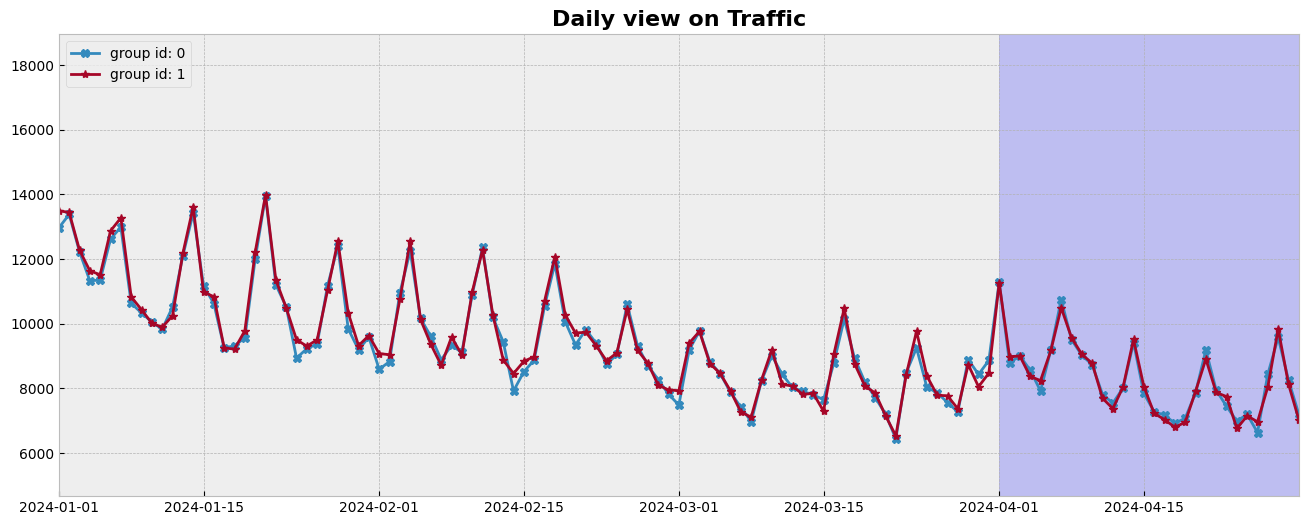

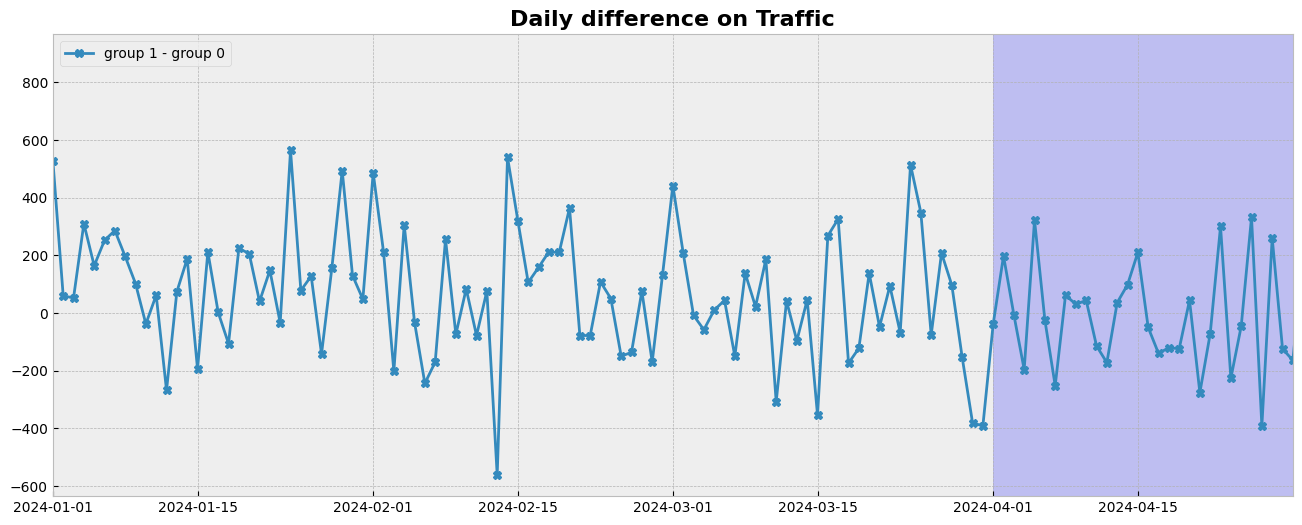

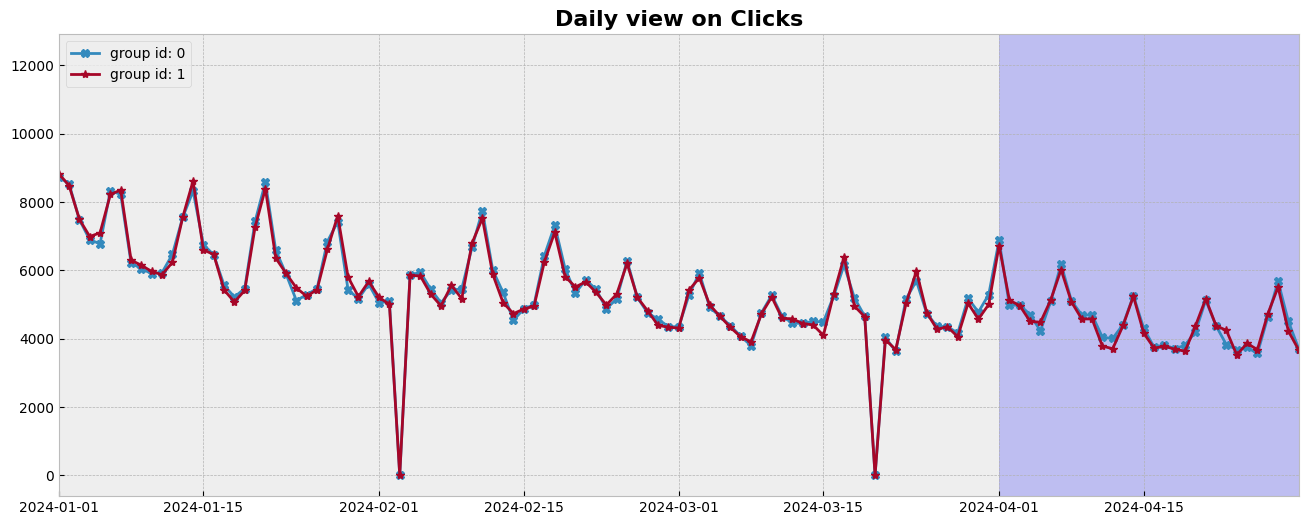

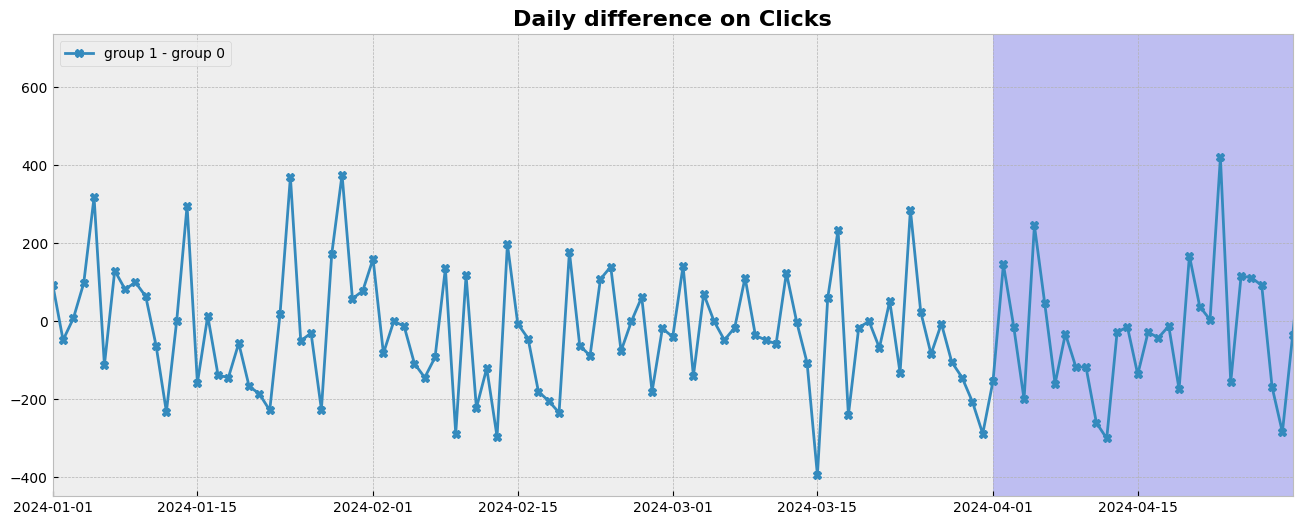

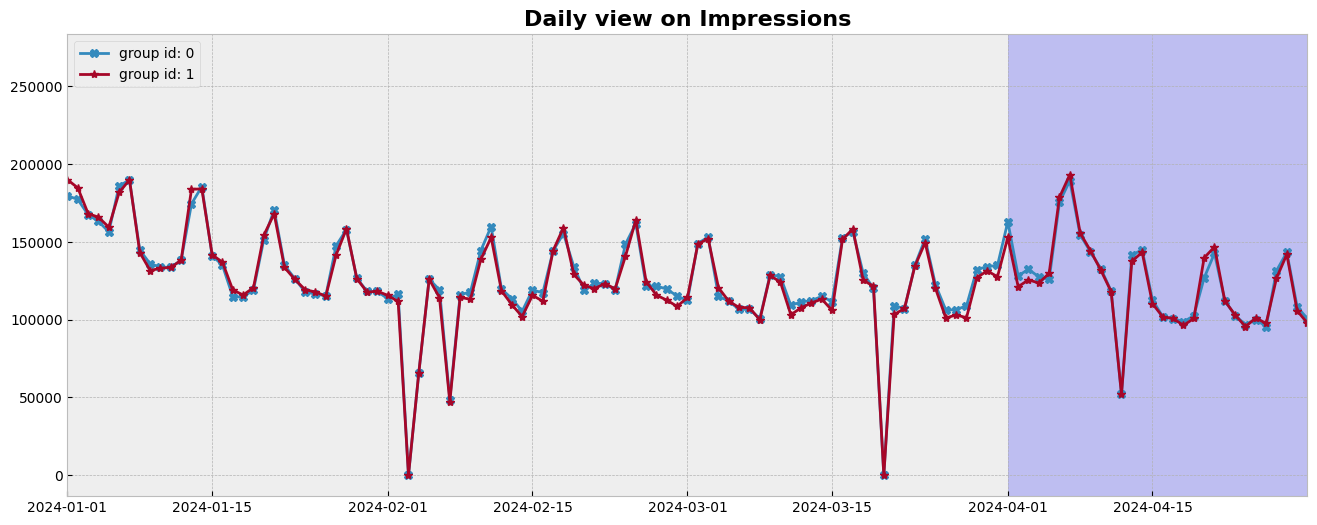

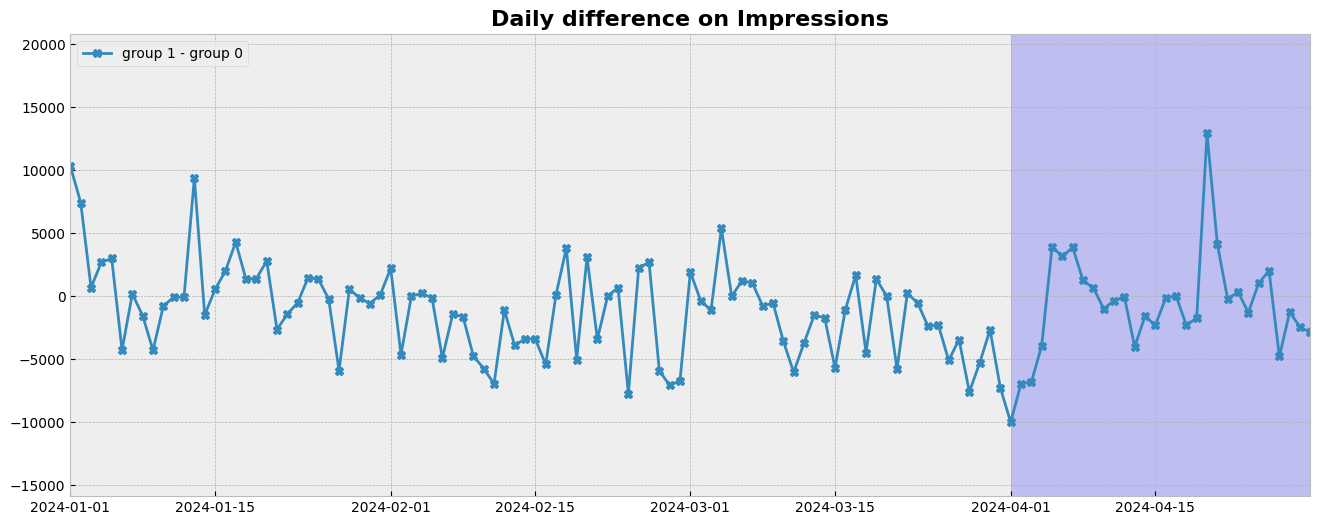

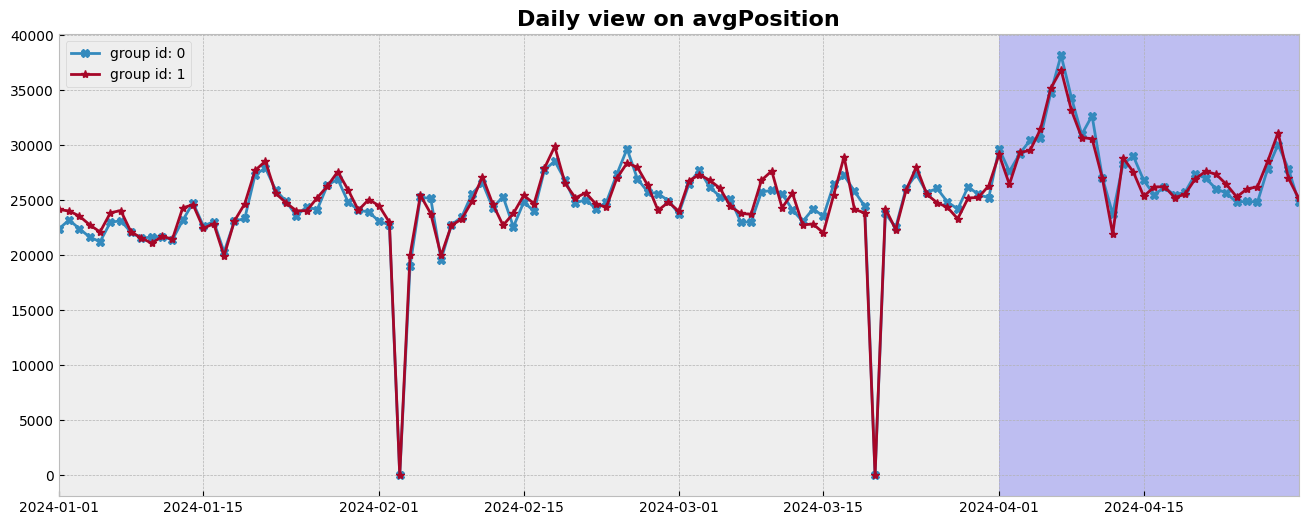

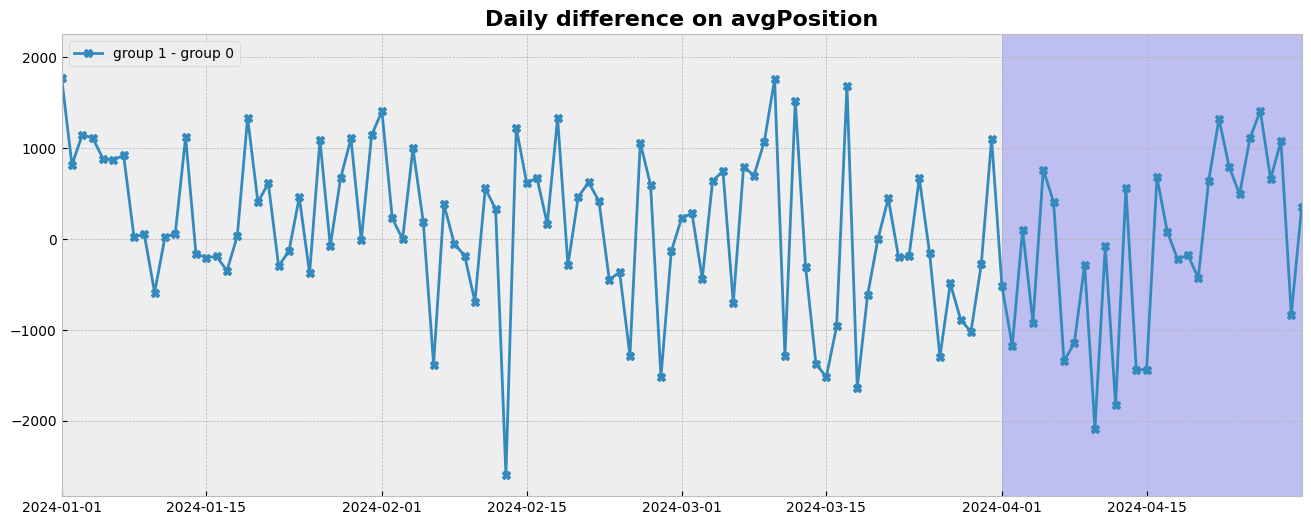

In [24]:
plot_comparisons(daily_data=final_gemini_design_data, 
                metrics=KPI_cols, 
                group_column = 'TestGroup', 
                date_column = date_column,
                group_ids=[0, 1], 
                group_ratios=[0.5, 0.5], 
                time_range=[training_start_date, validation_end_date], 
                shade_window=[validation_start_date, validation_end_date], 
                include_diff=True)

### Check whether the difference between groups is statistically significant at baseline

#### **If some of the KPIs are too imbalanced, we recommend removing some of the metrics that are not primary KPIs. Sometimes including too many metrics can result in an overall greater imbalance in the metrics. To do this, change the KPI_cols list right before Step 3.**

### Use 'compute_lift' to pull the Validation Read to check whether the groups have no sig. differences
- The output will be the daily average of the control group (test_control) and treatment group (test_treatment) *at the subgroup level*, as well as the daily difference between the groups (measurement lift) *at the subgroup level* and a confidence interval*
- In addition, a p-value is provided and the lift ratio (measured lift/test_control). 
- If the p-value is less than 0.10, you can assume that there is less than a 10% chance to observe this effect under the null hypothesis (i.e., the null hypothesis assumes that there is no effect). A p-value threshold of 0.05 or 0.10 is often standard to assume a significant effect.

In [25]:
y = gemini.TestMeasure(data = final_gemini_design_data, 
                       metrics = KPI_cols, 
                       test_window = TimeWindow(validation_start_date, validation_end_date), 
                       assignment_column = 'TestGroup', 
                       subgroup_column = 'SubGroup',
                       date_column = date_column, 
                       group_names = {'control': 0, 'treatment': 1},
                       split_ratios = {'control': 0.5, 'treatment': 0.5})
y.measure_lift(method = 'gemini_v5')

Group_0_daily_average  Group_1_daily_average      Scale  \
Traffic                4144.000000             4134.00000  treatment   
Clicks                 2259.033333             2241.70000  treatment   
Impressions           61781.433333            61433.30000  treatment   
avgPosition           14119.997186            14062.00321  treatment   

             Group_0_daily_average_scaled  Group_1_daily_average_scaled  \
Traffic                       4144.000000                    4134.00000   
Clicks                        2259.033333                    2241.70000   
Impressions                  61781.433333                   61433.30000   
avgPosition                  14119.997186                   14062.00321   

             Daily_lift_scaled                              Daily_lift_CI  \
Traffic             -10.000000  (-126.46162542956093, 106.46162542956135)   
Clicks              -17.333333     (-91.8180618425962, 57.15139517592965)   
Impressions        -348.133333    (-3301.760272822023, 2605.493606155359)   
avgPosition         -57.993976     (-405.6158229113984, 289.627870720767)   

              P_value  Lift_ratio  Cumulative_lift_scaled  \
Traffic      0.887684   -0.002413             -300.000000   
Clicks       0.701888   -0.007673             -520.000000   
Impressions  0.846275   -0.005635           -10444.000000   
avgPosition  0.783768   -0.004107            -1739.819283   

                                    Cumulative_lift_CI Test_duration  \
Traffic       (-3793.848762886828, 3193.8487628868406)            30   
Clicks       (-2754.5418552778856, 1714.5418552778895)            30   
Impressions     (-99052.8081846607, 78164.80818466077)            30   
avgPosition   (-12168.474687341954, 8688.836121623011)            30   

             Confidence_level  
Traffic                   0.9  
Clicks                    0.9  
Impressions               0.9  
avgPosition               0.9

## Another option: Save table in GBQ with test splits 

In [26]:
# Use a project that you have permission to write to
pandas_gbq.to_gbq(
    best_split, 'analysis_seo.wfuk_quickview_removal_test_split', project_id='wf-gcp-us-ae-mktg-prod', if_exists='replace',
)

/opt/conda/lib/python3.7/contextlib.py:82: ResourceWarning: unclosed <ssl.SSLSocket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.240.255.118', 35736), raddr=('142.251.180.95', 443)>
  self.gen = func(*args, **kwds)
100%|██████████| 1/1 [00:00<00:00, 5825.42it/s]


# Gemini Measurement after the test launches

- For any pair of (treatment, control), use function __measure_lift__ to compute the incrementality.
- **Mandatory parameters to include:**
    - **data**: pd.DataFrame storing daily level metrics for each subgroup
    - **metrics**: list with metric names
    - **test_window**: TimeWindow, for the measurement period
        

- **Optional parameters to include:**
    - **pretest_window**: TimeWindow, for the prior test period
    - **assignment_column**: string for the name of assignment column
                        default value: "TestGroup"
    - **subgroup_column**: string for the name of subgroup column
                        default value: "SubGroup"
    - **date_column**: string for the name of date column
                        default value: "date"
    - **conf_level**: float, confidence level, default: 0.9
    - **tail**: int, 1 for single tail and 2 for two-tail
    - **split_ratios**: dictionary containing group shares for the two groups to use for measurement. Should be specified as: {'control': \<control group share\>, 'treatment': \<treatment group share\>}, where lift is interpreted as how treatment changed relative to control.
    - **group_names**: dictionary containing group ids for the two groups to use for measurement. Should be specified as: {'control': \<control group name\>, 'treatment': \<treatment group name\>}, where lift is interpreted as how treatment changed relative to control. default value: {'control': 0, 'treatment': 1}
    - **scale_to**: options are 'full-scale', 'treatment', 'control' (default: 'treatment'). 'treatment' will report lift values on the observed data scale (i.e., the actual amount of lift for the treatment group); 'full-scale' will scale the lift to represent the total opportunity represented by this treatment - the lift that we WOULD EXPECT if we were to apply the treatment to the entire sample, rather than just the proportion of the sample contained in the treatment group; 'control' will scale the data to the control group, which is not typically needed.
    
**There is also an option to adjust for the pre-calibration time period using the 'pretest_window' parameter .** The Calibrated version accounts for the period between designing the test and launching the test, so helps to offset an initial imbalance between the groups. This is also important for the measurement of secondary KPIs, which were not used in the initial test design. 

In [54]:
# validation period
validation_start_date = '2024-04-01'
validation_end_date = '2024-04-30'
# test period
test_start_date = '2024-05-21'
test_end_date = '2024-06-18'
KPI_measurement_cols = ['Visits','PDP','ATC','Converted','Bounced','Acquisitions','PDP_Rate','ATC_Rate','Conversion_Rate','Bounce_Rate','Acquisition_Rate',
                        'unique_keywords','Impressions','Ranks','Clicks','CTR',
                        'GRS','AOV','GRS_Themis','Orders_Themis','AOV_Themis']

date_column_meas = 'sessionstartdate'

measurement_query_params = {'validation_start_date': validation_start_date, 'validation_end_date': validation_end_date, 'test_start_date': test_start_date, 'test_end_date': test_end_date}

In [55]:
%%bigquery measurement_df
SELECT * from  `wf-gcp-us-ae-mktg-prod.analysis_seo.wfuk_quickview_removal_test_kpis_TR`

Query is running:   0%|          |

Downloading:   0%|          |

In [56]:
measurement_df.head(5)

sessionstartdate  testgroup  subgroup  Visits  PDP  ATC  Converted  Bounced  \
0       2024-04-01          0        19     508  235   14          5      194   
1       2024-04-01          0         4     619  288   18          5      226   
2       2024-04-01          1        17     534  260   20          7      211   
3       2024-04-01          0         7     558  252   19          2      218   
4       2024-04-01          0        12     608  257   18          4      252   

   Acquisitions  PDP_Rate  ...  Impressions     Ranks  avg_position  Clicks  \
0             2  0.462598  ...         9373  7.578011      8.365110     304   
1             2  0.465267  ...        10044  9.653047      8.756592     379   
2             2  0.486891  ...         7712  8.794295      8.425956     328   
3             3  0.451613  ...         8383  8.372754      7.735646     345   
4             1  0.422697  ...         8387  9.093728      8.285775     385   

        CTR             GRS            AOV     GRS_Themis  Orders_Themis  \
0  0.032434   182.420000000   36.484000000  132.651713592       0.624105   
1  0.037734  1026.510000000  205.302000000  371.079956902       1.627082   
2  0.042531   590.640000000   84.377142857  123.965946130       2.060546   
3  0.041155   103.410000000   51.705000000  153.455683882       1.085429   
4  0.045904   144.890000000   36.222500000  185.586465662       0.689359   

   AOV_Themis  
0  212.547003  
1  228.064628  
2   60.161692  
3  141.377916  
4  269.215798  

[5 rows x 25 columns]

In [62]:
measurement_df.dtypes

sessionstartdate     dbdate
testgroup             Int64
subgroup              Int64
Visits              float32
PDP                 float32
ATC                 float32
Converted           float32
Bounced             float32
Acquisitions        float32
PDP_Rate            float32
ATC_Rate            float32
Conversion_Rate     float32
Bounce_Rate         float32
Acquisition_Rate    float32
unique_keywords     float32
Impressions         float32
Ranks               float32
avg_position        float32
Clicks              float32
CTR                 float32
GRS                 float32
AOV                 float32
GRS_Themis          float32
Orders_Themis       float32
AOV_Themis          float32
dtype: object

In [61]:
measurement_df['Visits'] = measurement_df['Visits'].astype('float32')
measurement_df['PDP'] = measurement_df['PDP'].astype('float32')
measurement_df['ATC'] = measurement_df['ATC'].astype('float32')
measurement_df['Converted'] = measurement_df['Converted'].astype('float32')
measurement_df['Bounced'] = measurement_df['Bounced'].astype('float32')
measurement_df['Acquisitions'] = measurement_df['Acquisitions'].astype('float32')
measurement_df['PDP_Rate'] = measurement_df['PDP_Rate'].astype('float32')
measurement_df['ATC_Rate'] = measurement_df['ATC_Rate'].astype('float32')
measurement_df['Conversion_Rate'] = measurement_df['Conversion_Rate'].astype('float32')
measurement_df['Bounce_Rate'] = measurement_df['Bounce_Rate'].astype('float32')
measurement_df['Acquisition_Rate'] = measurement_df['Acquisition_Rate'].astype('float32')
measurement_df['unique_keywords'] = measurement_df['unique_keywords'].astype('float32')
measurement_df['Impressions'] = measurement_df['Impressions'].astype('float32')
measurement_df['Ranks'] = measurement_df['Ranks'].astype('float32')
measurement_df['avg_position'] = measurement_df['avg_position'].astype('float32')
measurement_df['Clicks'] = measurement_df['Clicks'].astype('float32')
measurement_df['CTR'] = measurement_df['CTR'].astype('float32')
measurement_df['GRS'] = measurement_df['GRS'].astype('float32')
measurement_df['AOV'] = measurement_df['AOV'].astype('float32')
measurement_df['GRS_Themis'] = measurement_df['GRS_Themis'].astype('float32')
measurement_df['Orders_Themis'] = measurement_df['Orders_Themis'].astype('float32')
measurement_df['AOV_Themis'] = measurement_df['AOV_Themis'].astype('float32')

### Use 'measurement_lift' to pull Measurement Test Read (adjusting for pre-test window)
- The output will be the daily average of the control group (test_control) and treatment group (test_treatment) *at the subgroup level*, as well as the daily difference between the groups (measurement lift) *at the subgroup level* and a confidence interval*
- In addition, a p-value is provided and the lift ratio (measured lift/test_control). 
- If the p-value is less than 0.10, you can assume that there is less than a 10% chance to observe this effect under the null hypothesis (i.e., the null hypothesis assumes that there is no effect). A p-value threshold of 0.05 or 0.10 is often standard to assume a significant effect.

**This example adjusts for the pre-calibration time period using the 'pretest_window' parameter.** The Calibrated version accounts for the period between designing the test and launching the test, so helps to offset an initial imbalance between the groups. This is also important for the measurement of secondary KPIs, which were not used in the initial test design. 

In [66]:
measurement_df

sessionstartdate  testgroup  subgroup  Visits    PDP   ATC  Converted  \
0          2024-04-01          0        19   508.0  235.0  14.0        5.0   
1          2024-04-01          0         4   619.0  288.0  18.0        5.0   
2          2024-04-01          1        17   534.0  260.0  20.0        7.0   
3          2024-04-01          0         7   558.0  252.0  19.0        2.0   
4          2024-04-01          0        12   608.0  257.0  18.0        4.0   
...               ...        ...       ...     ...    ...   ...        ...   
1575       2024-06-18          0        16   320.0  141.0  12.0        5.0   
1576       2024-06-18          0         3   314.0  139.0  11.0        1.0   
1577       2024-06-18          1         2   318.0  147.0  12.0        4.0   
1578       2024-06-18          1         1   281.0  113.0   6.0        3.0   
1579       2024-06-18          0         7   320.0  125.0   7.0        2.0   

      Bounced  Acquisitions  PDP_Rate  ...  Impressions     Ranks  \
0       194.0           2.0  0.462598  ...       9373.0  7.578012   
1       226.0           2.0  0.465267  ...      10044.0  9.653047   
2       211.0           2.0  0.486891  ...       7712.0  8.794294   
3       218.0           3.0  0.451613  ...       8383.0  8.372754   
4       252.0           1.0  0.422697  ...       8387.0  9.093728   
...       ...           ...       ...  ...          ...       ...   
1575    124.0           1.0  0.440625  ...       4412.0  7.693903   
1576    117.0           3.0  0.442675  ...       3863.0  7.634041   
1577    115.0           1.0  0.462264  ...       4479.0  7.646060   
1578    125.0           1.0  0.402135  ...       3366.0  7.283244   
1579    137.0           3.0  0.390625  ...       4464.0  8.647603   

      avg_position  Clicks       CTR          GRS         AOV  GRS_Themis  \
0         8.365110   304.0  0.032434   182.419998   36.484001  132.651718   
1         8.756592   379.0  0.037734  1026.510010  205.302002  371.079956   
2         8.425956   328.0  0.042531   590.640015   84.377144  123.965942   
3         7.735646   345.0  0.041155   103.410004   51.705002  153.455688   
4         8.285775   385.0  0.045904   144.889999   36.222500  185.586472   
...            ...     ...       ...          ...         ...         ...   
1575      7.470614   192.0  0.043518   922.960022  184.591995  230.890839   
1576      8.586097   190.0  0.049185   165.820007  165.820007  203.139328   
1577      7.688986   190.0  0.042420   484.890015  121.222504  945.639160   
1578      8.087776   151.0  0.044860   226.600006   75.533333   96.971016   
1579      8.256663   185.0  0.041443   175.110001   87.555000   61.851330   

      Orders_Themis  AOV_Themis  
0          0.624105  212.546997  
1          1.627082  228.064621  
2          2.060546   60.161694  
3          1.085429  141.377914  
4          0.689359  269.215790  
...             ...         ...  
1575       1.277520  180.733566  
1576       1.185469  171.357803  
1577       1.313205  720.100220  
1578       0.513123  188.982040  
1579       0.547180  113.036430  

[1580 rows x 25 columns]

In [67]:
y = gemini.TestMeasure(data = measurement_df, 
                       metrics = KPI_measurement_cols, 
                       test_window = TimeWindow(test_start_date, test_end_date),
                       pretest_window = TimeWindow(validation_start_date, validation_end_date),
                       assignment_column = 'testgroup', 
                       subgroup_column = 'subgroup',
                       date_column = date_column_meas, 
                       group_names = {'control': 0, 'treatment': 1},
                       split_ratios = {'control': 0.5, 'treatment': 0.5})
calibrated_read = y.measure_lift()
calibrated_read

Group_0_daily_average  Group_1_daily_average      Scale  \
Visits                      3312.275862            3014.620690  treatment   
PDP                         1436.275862            1327.068966  treatment   
ATC                          108.344828             100.206897  treatment   
Converted                     25.448276              23.241379  treatment   
Bounced                     1301.137931            1157.034483  treatment   
Acquisitions                  14.137931              11.586207  treatment   
PDP_Rate                       4.331801               4.397847  treatment   
ATC_Rate                       0.326681               0.331834  treatment   
Conversion_Rate                0.076099               0.077003  treatment   
Bounce_Rate                    3.932152               3.842435  treatment   
Acquisition_Rate               0.043022               0.039280  treatment   
unique_keywords             3844.620690            3626.137931  treatment   
Impressions                47379.275862           45394.586207  treatment   
Ranks                         82.180664              82.405246  treatment   
Clicks                      1919.586207            1847.206897  treatment   
CTR                            0.407730               0.409956  treatment   
GRS                         2658.061041            2468.629655  treatment   
AOV                          932.148710            1017.056951  treatment   
GRS_Themis                  1724.807751            1494.189279  treatment   
Orders_Themis                  9.855235               8.856880  treatment   
AOV_Themis                  1728.280298            1677.501890  treatment   

                  Group_0_daily_average_scaled  Group_1_daily_average_scaled  \
Visits                             3312.275862                   3014.620690   
PDP                                1436.275862                   1327.068966   
ATC                                 108.344828                    100.206897   
Converted                            25.448276                     23.241379   
Bounced                            1301.137931                   1157.034483   
Acquisitions                         14.137931                     11.586207   
PDP_Rate                              4.331801                      4.397847   
ATC_Rate                              0.326681                      0.331834   
Conversion_Rate                       0.076099                      0.077003   
Bounce_Rate                           3.932152                      3.842435   
Acquisition_Rate                      0.043022                      0.039280   
unique_keywords                    3844.620690                   3626.137931   
Impressions                       47379.275862                  45394.586207   
Ranks                                82.180664                     82.405246   
Clicks                             1919.586207                   1847.206897   
CTR                                   0.407730                      0.409956   
GRS                                2658.061041                   2468.629655   
AOV                                 932.148710                   1017.056951   
GRS_Themis                         1724.807751                   1494.189279   
Orders_Themis                         9.855235                      8.856880   
AOV_Themis                         1728.280298                   1677.501890   

                  Daily_lift_scaled  \
Visits                  -287.488506   
PDP                     -105.940230   
ATC                       -7.737931   
Converted                 -1.473563   
Bounced                 -135.536782   
Acquisitions              -2.318391   
PDP_Rate                   0.061800   
ATC_Rate                   0.004229   
Conversion_Rate            0.002714   
Bounce_Rate               -0.073012   
Acquisition_Rate          -0.003723   
unique_keywords         -213.249425   
Impressions            -1465.322989   
Ranks           

### Visualize measurement data

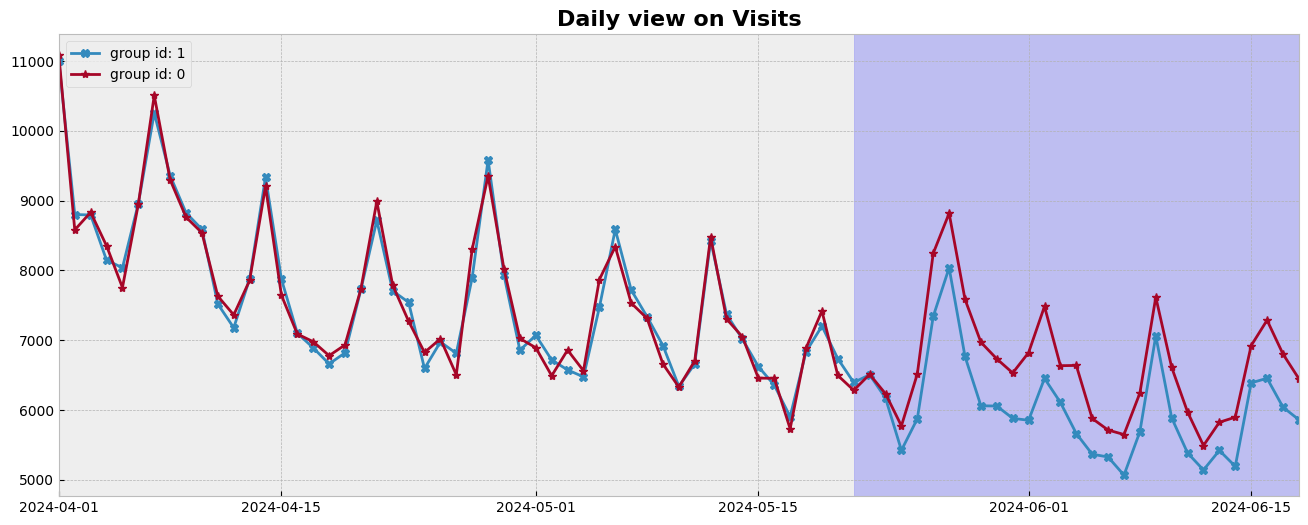

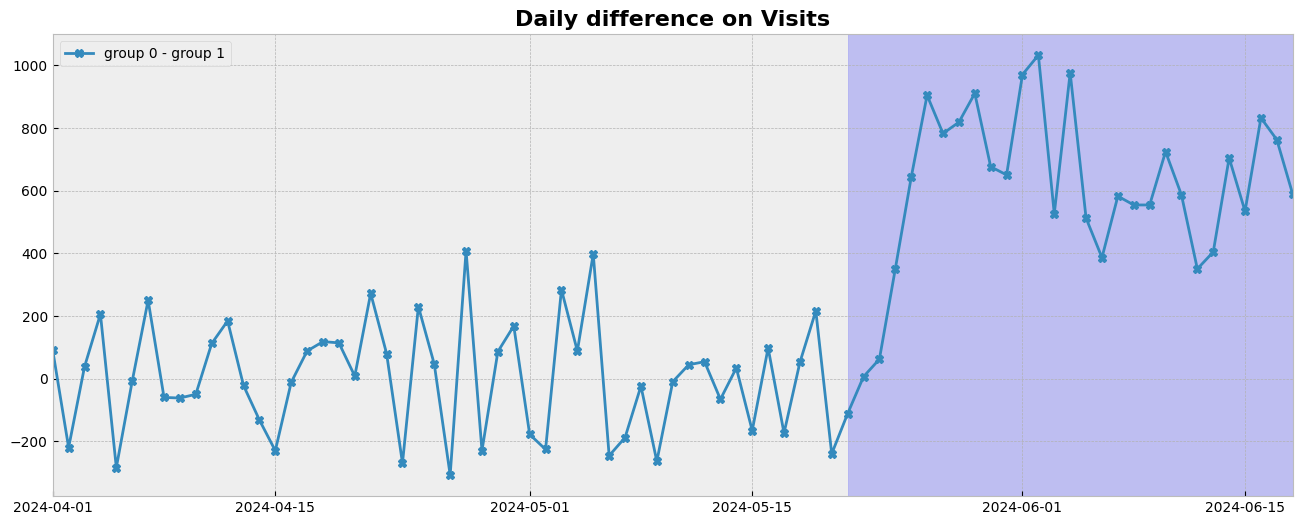

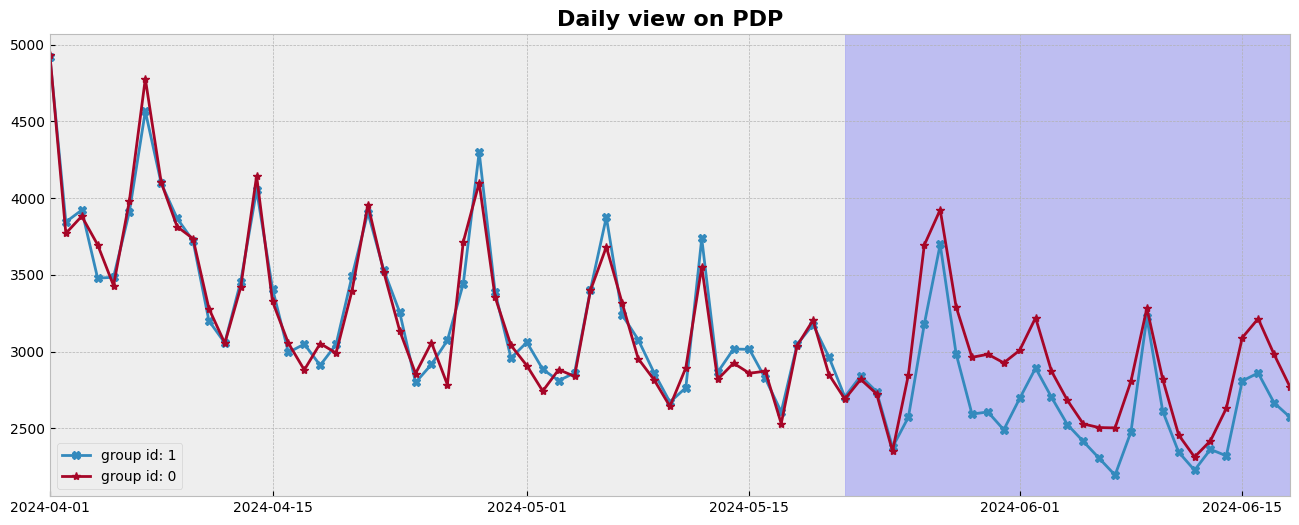

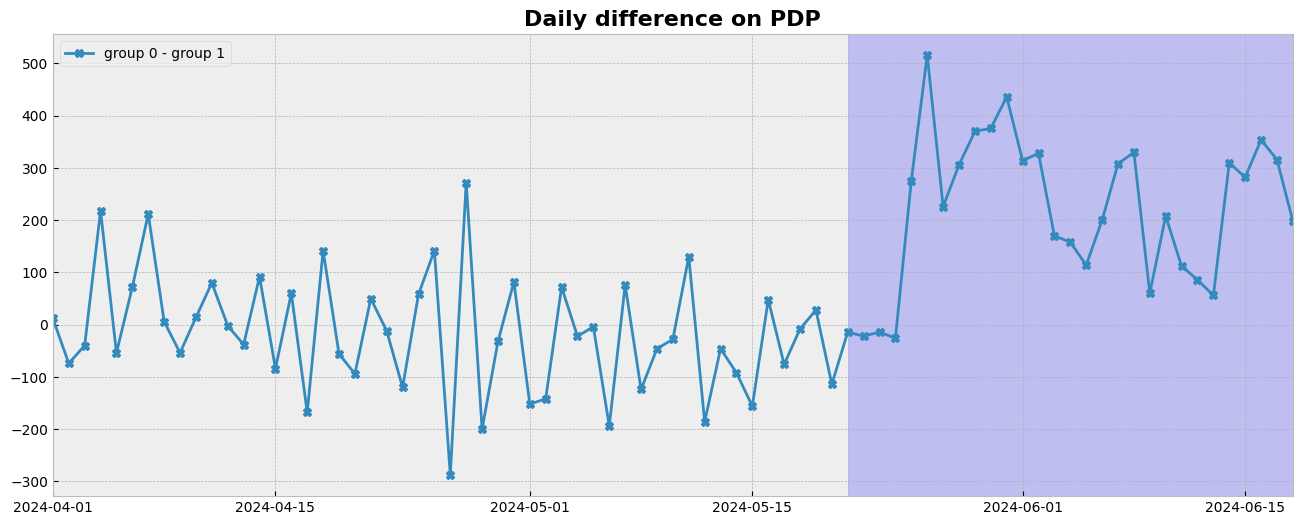

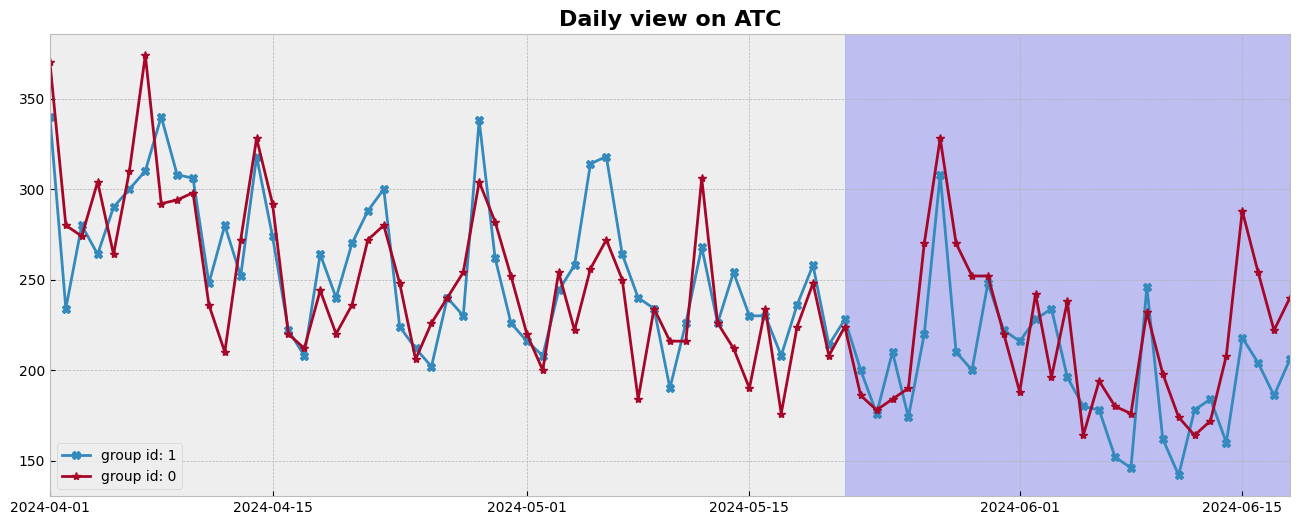

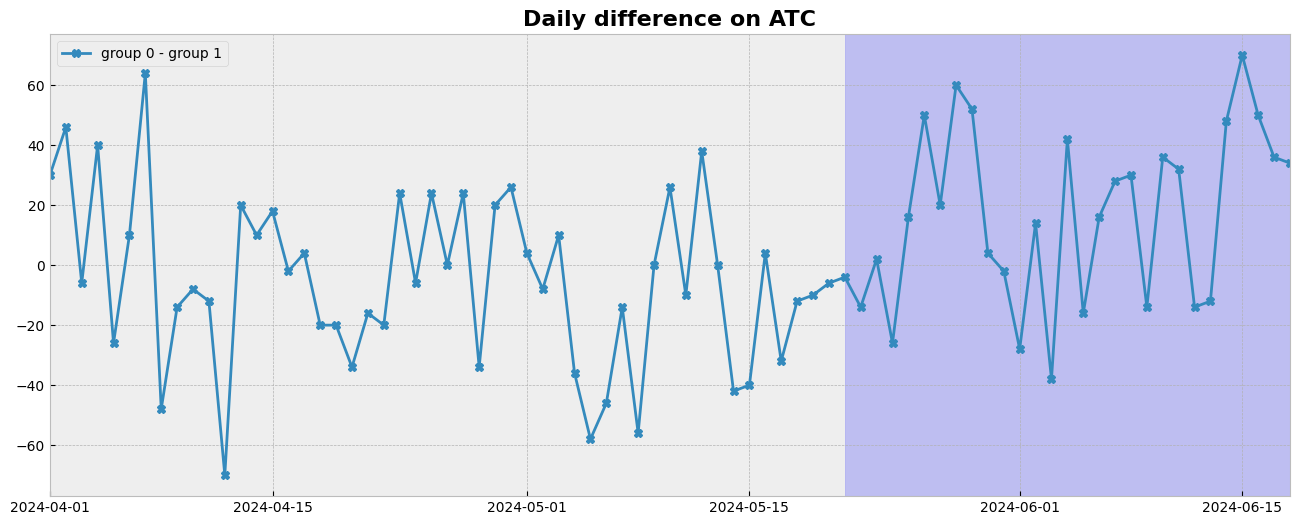

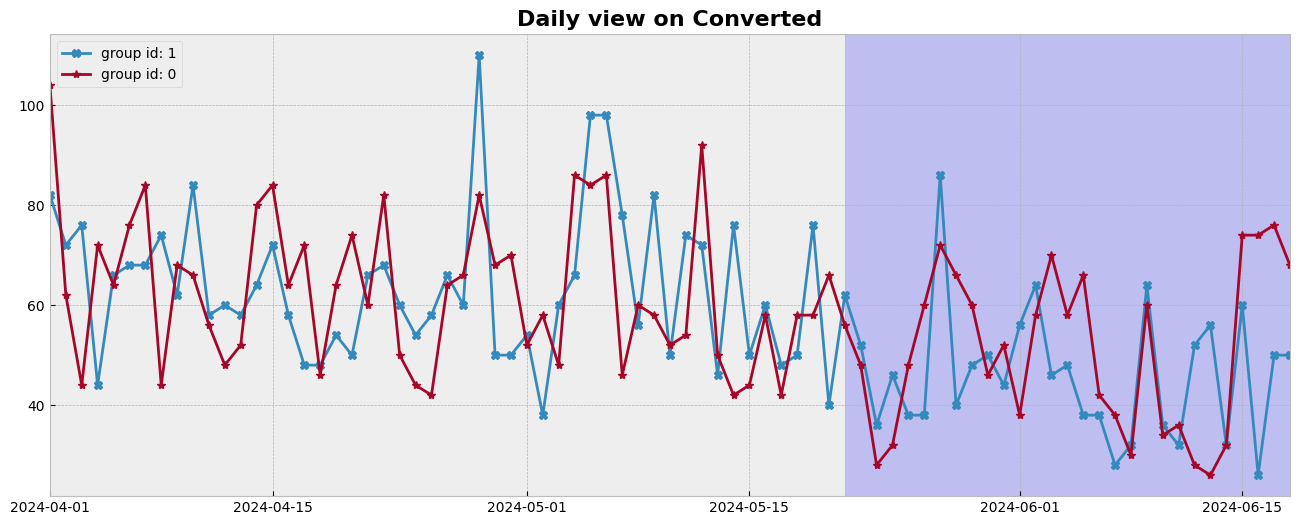

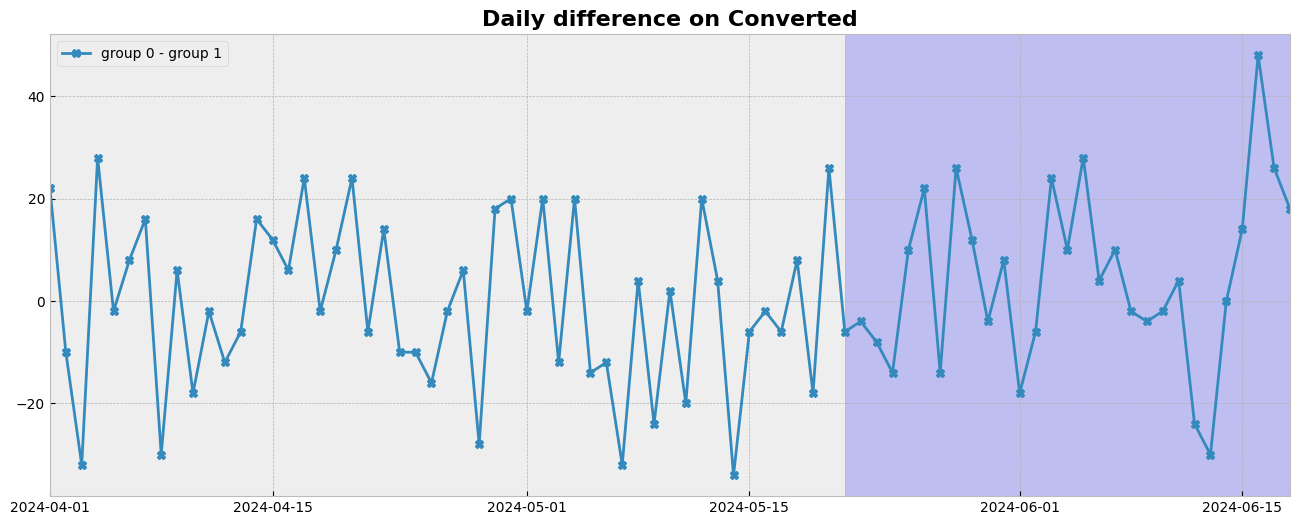

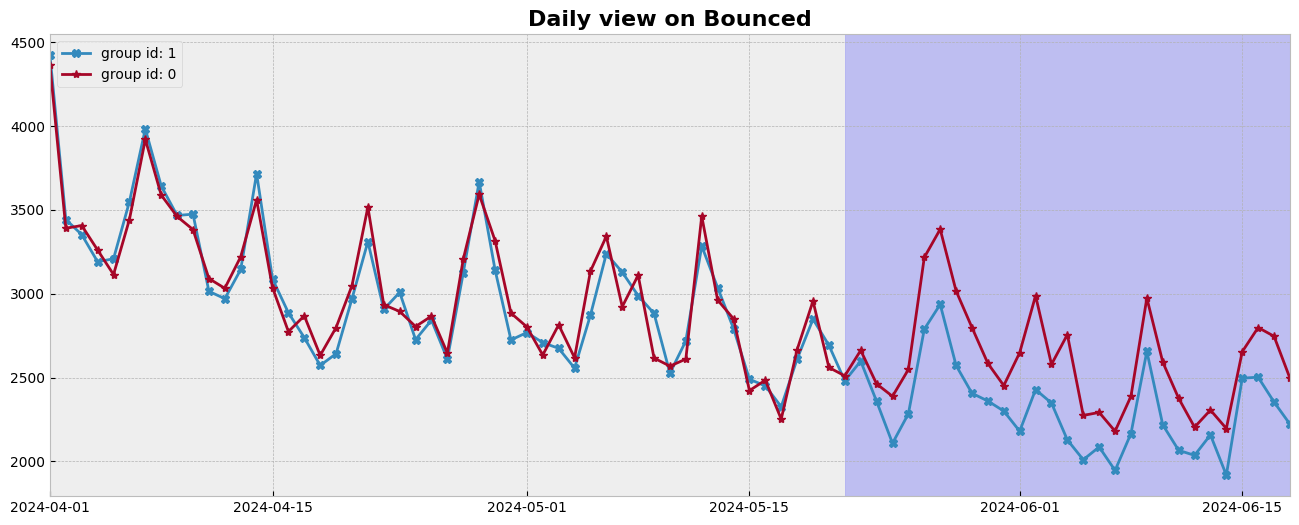

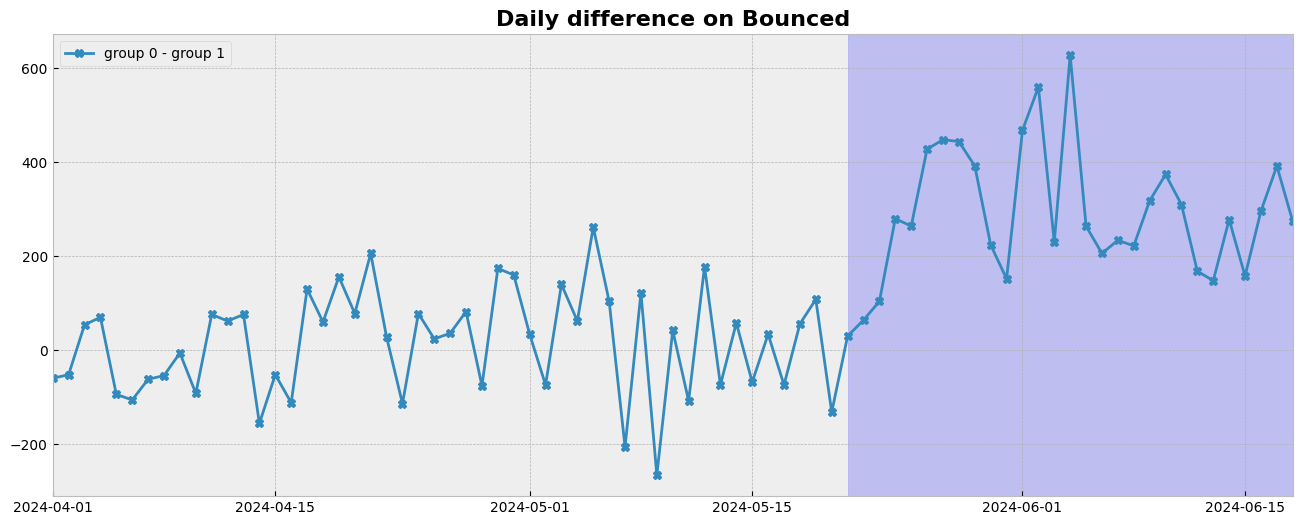

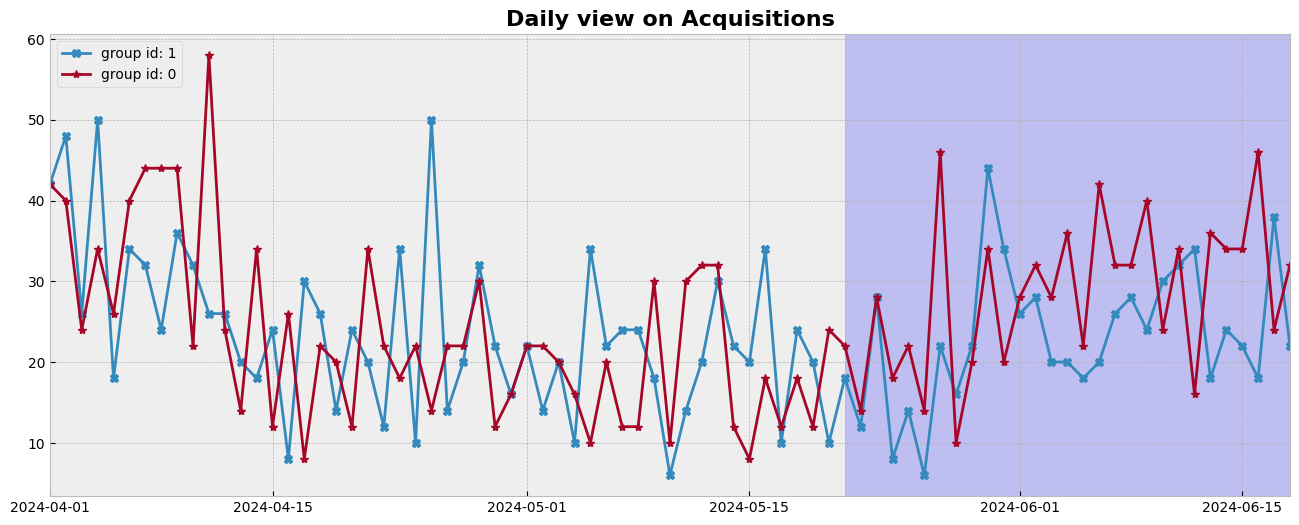

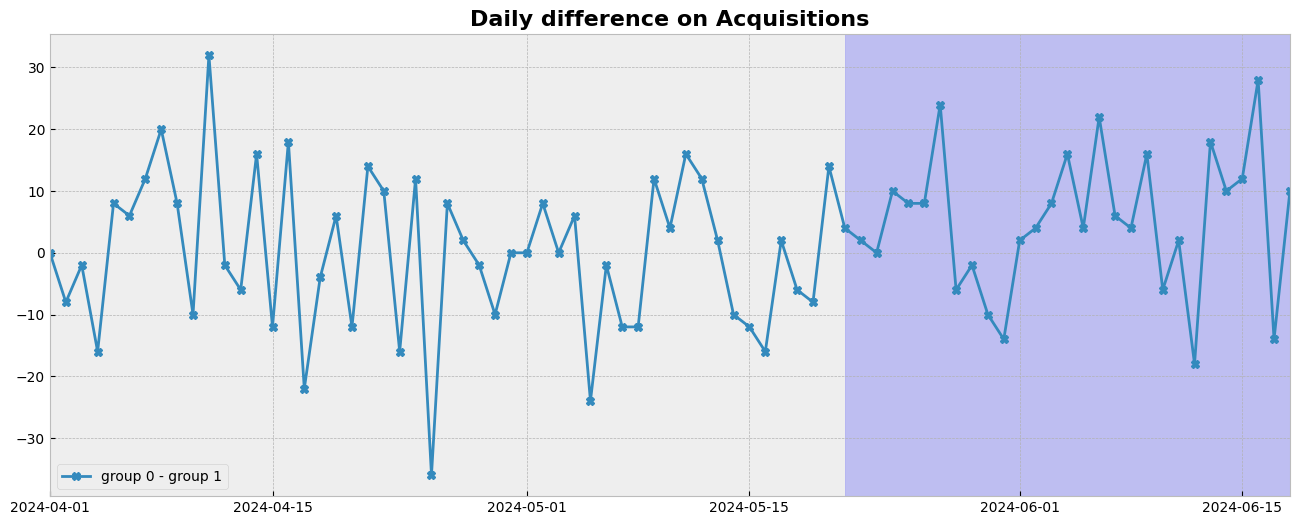

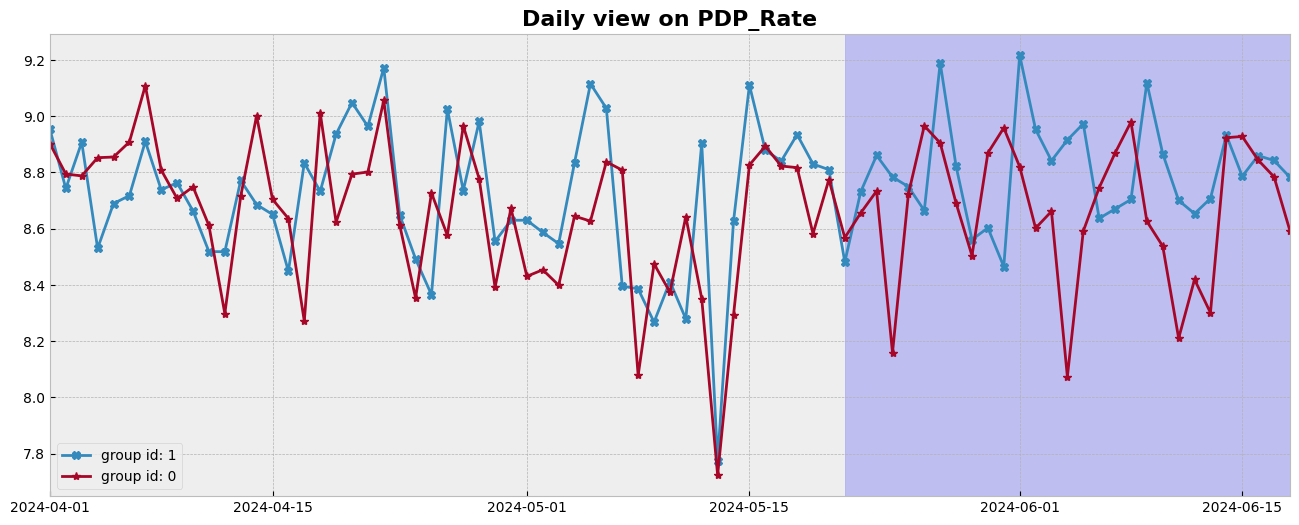

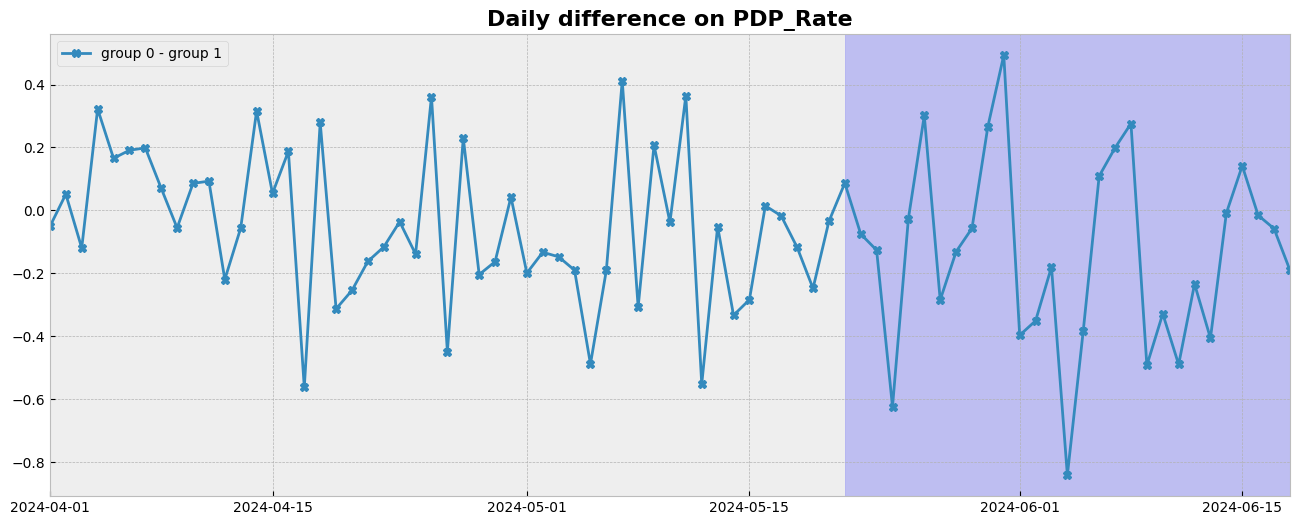

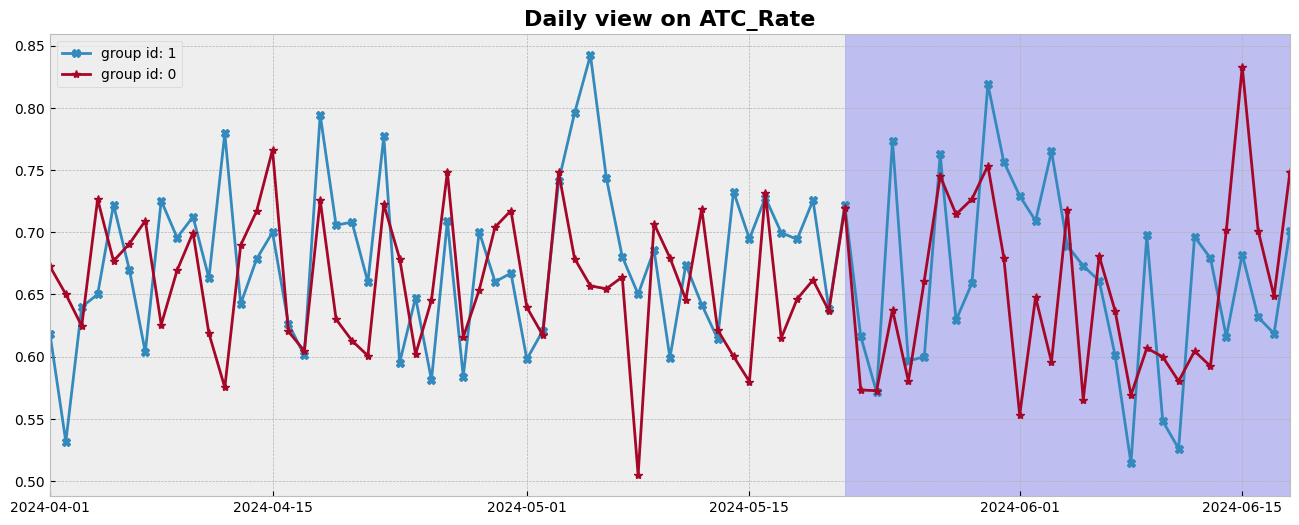

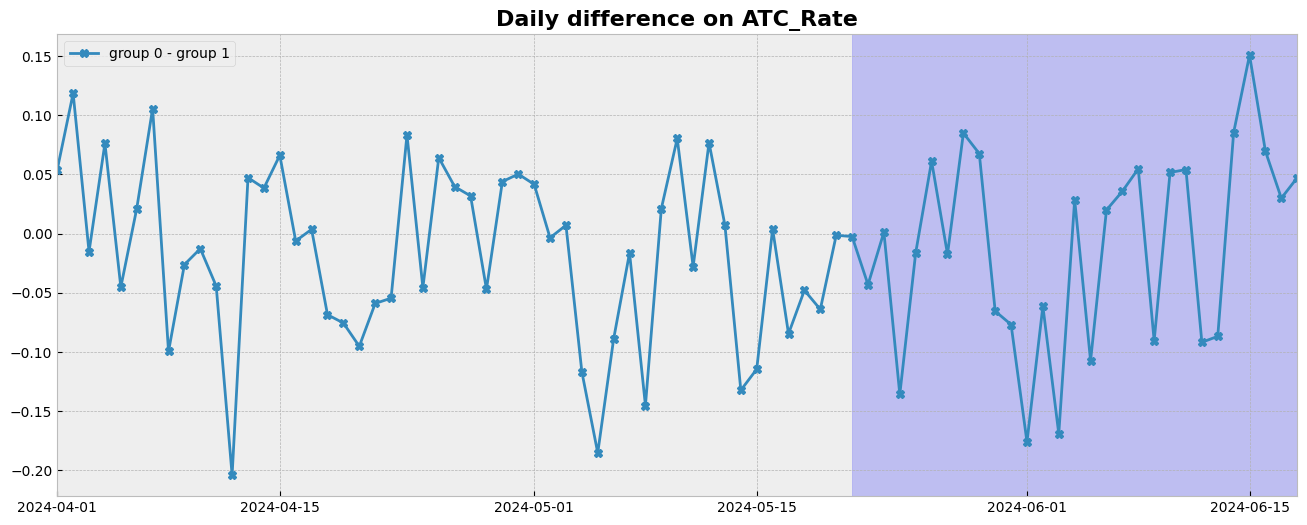

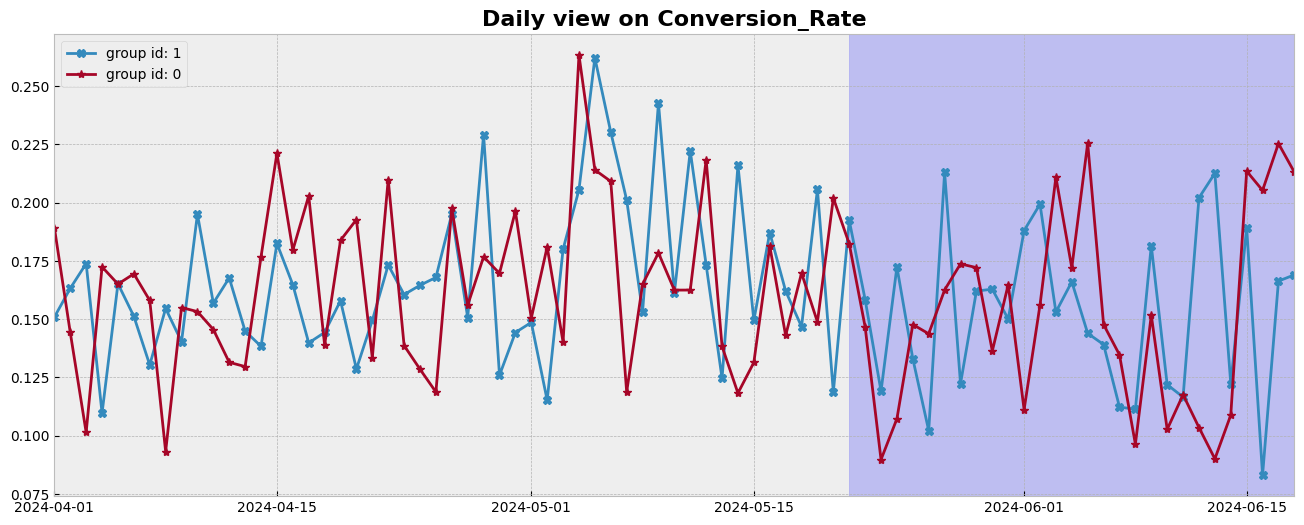

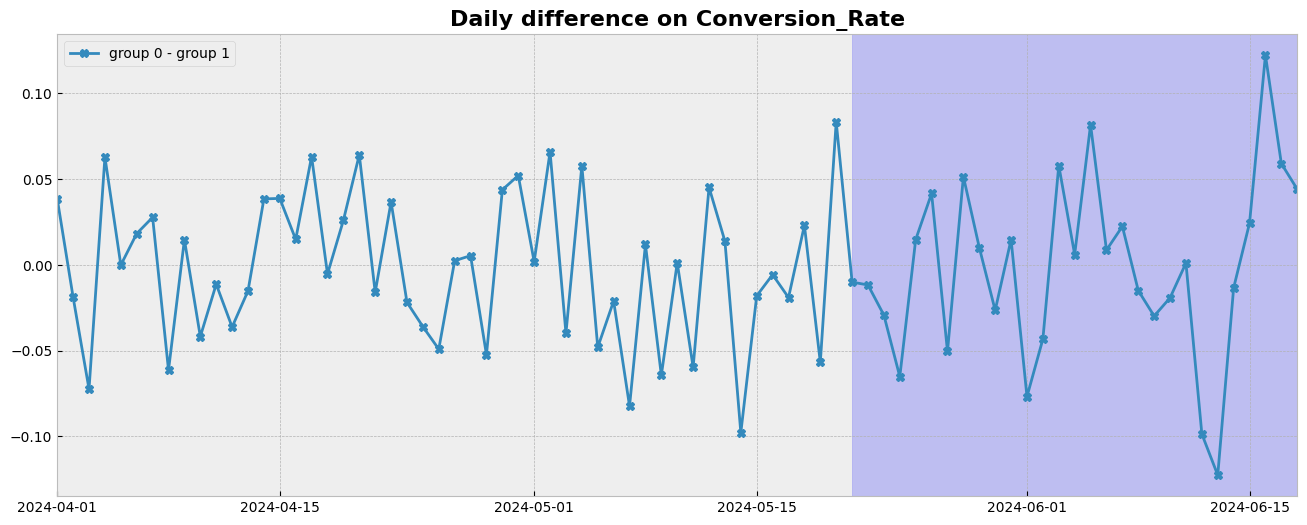

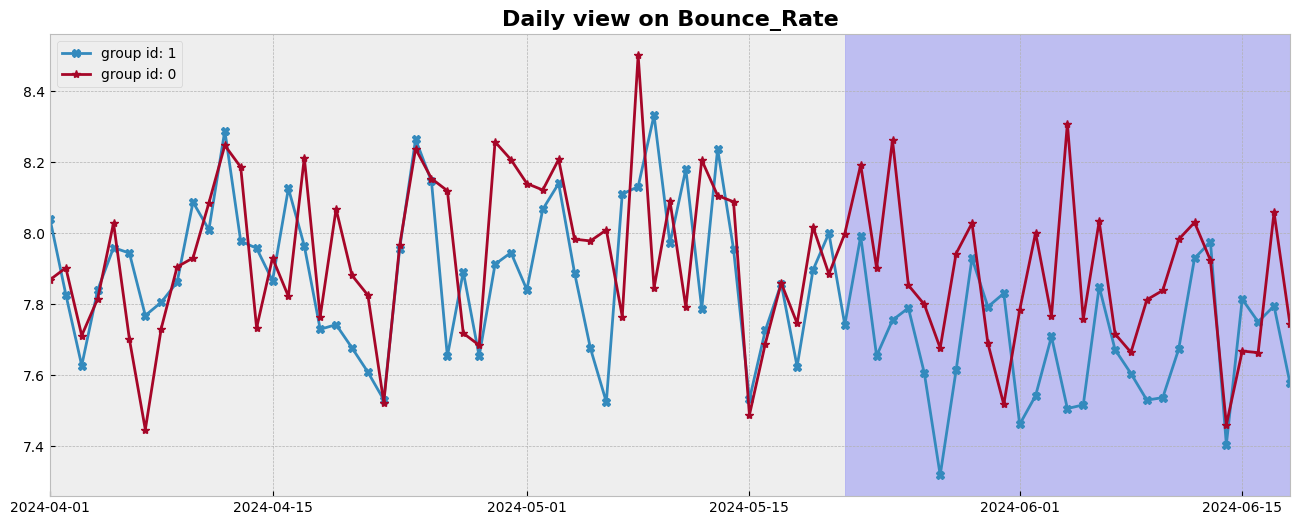

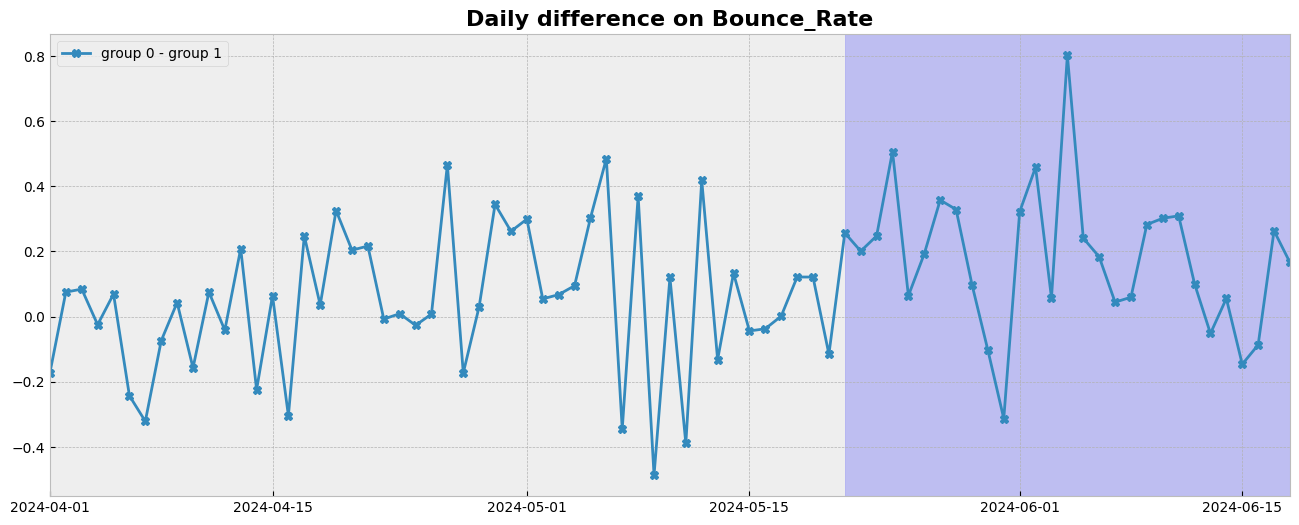

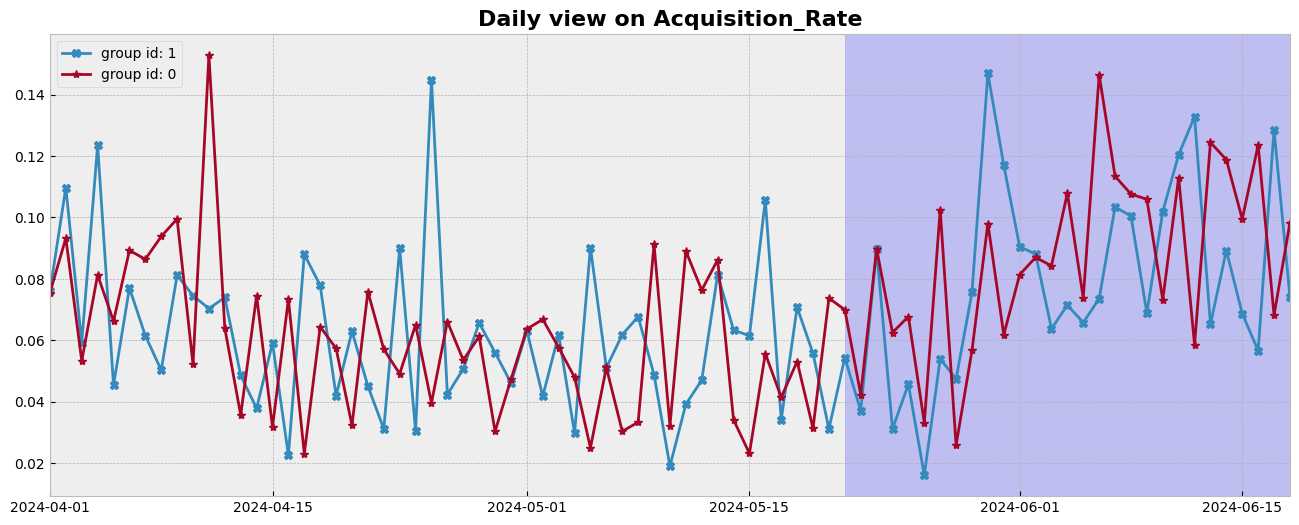

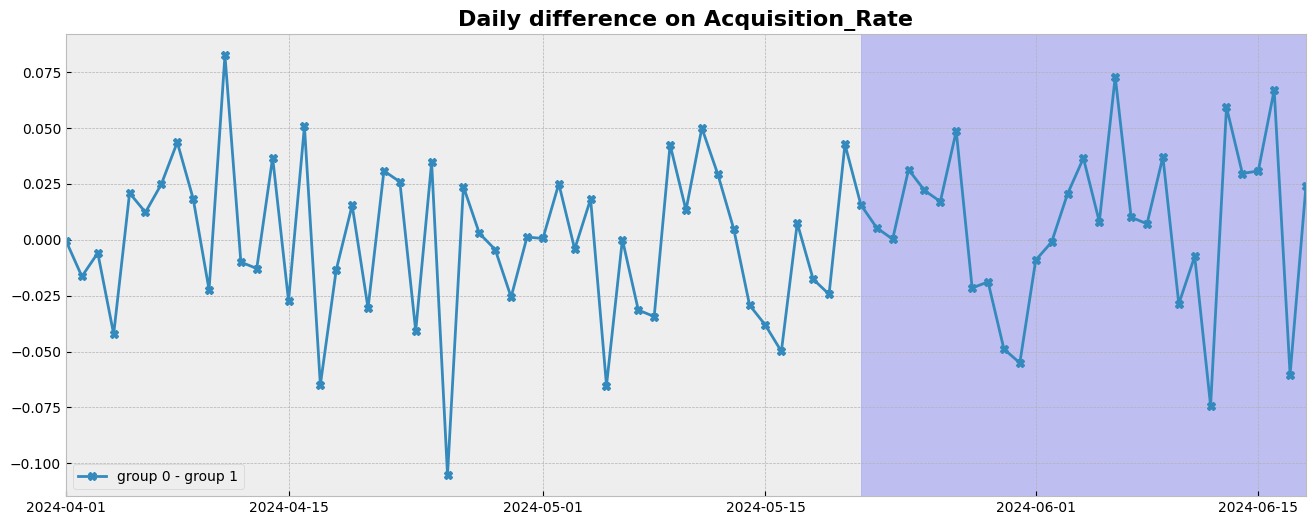

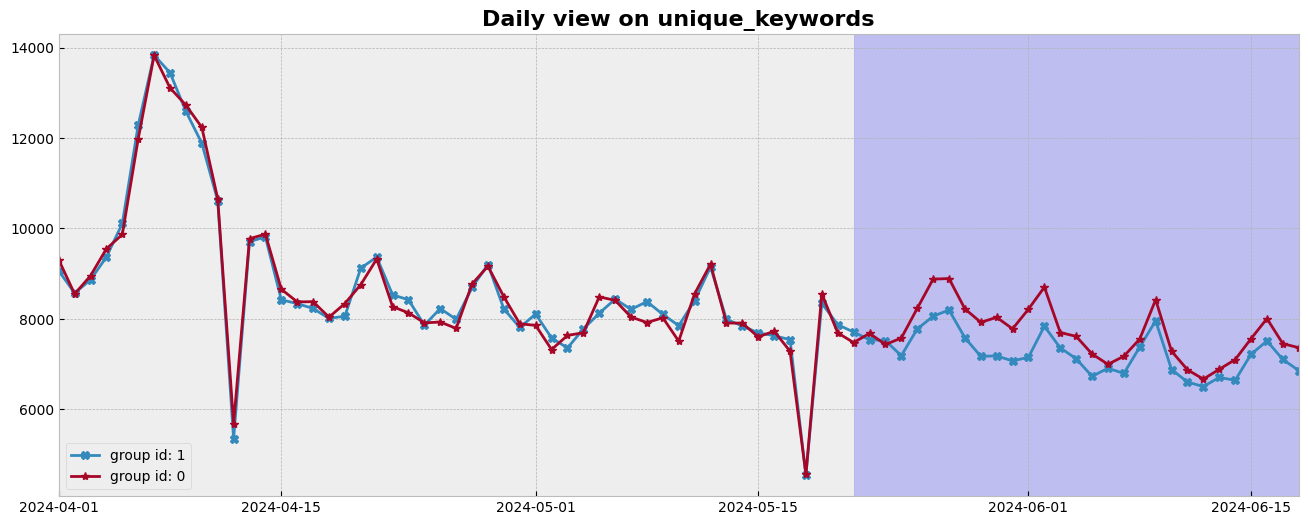

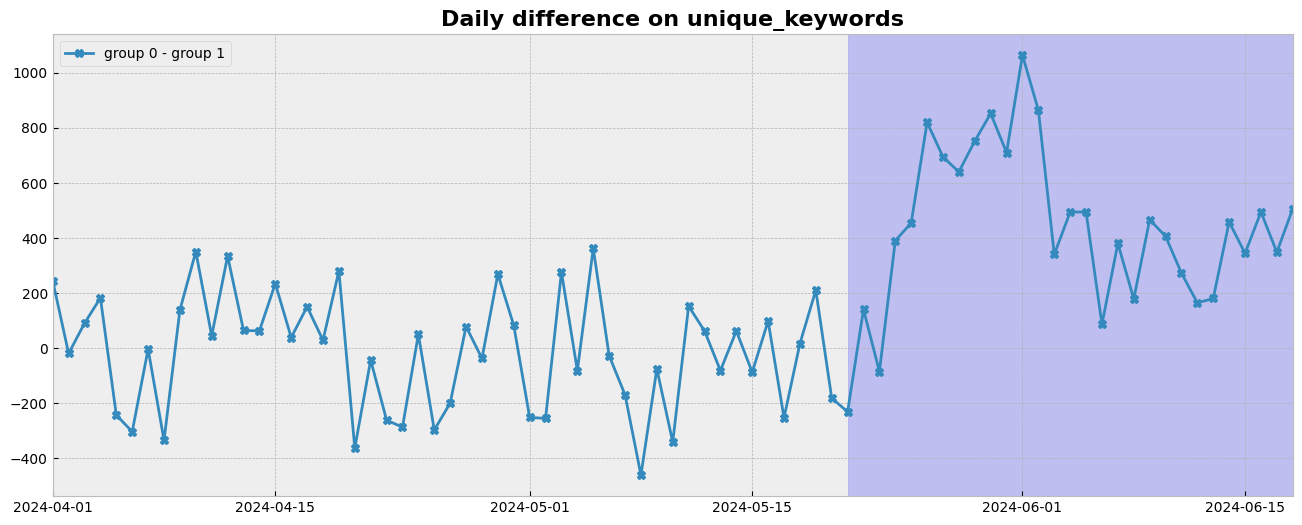

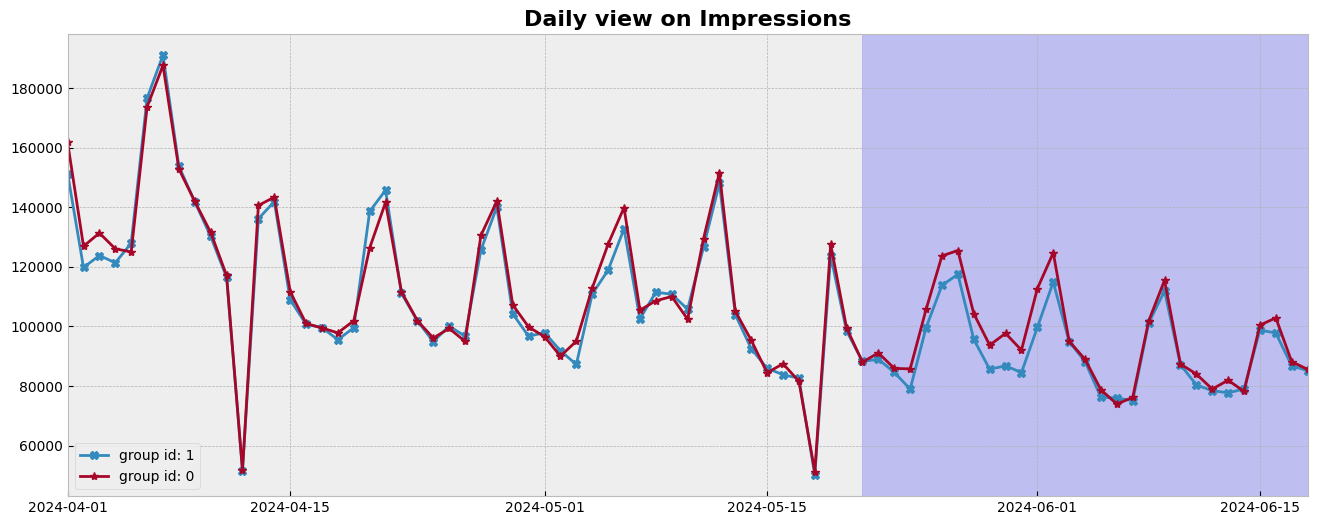

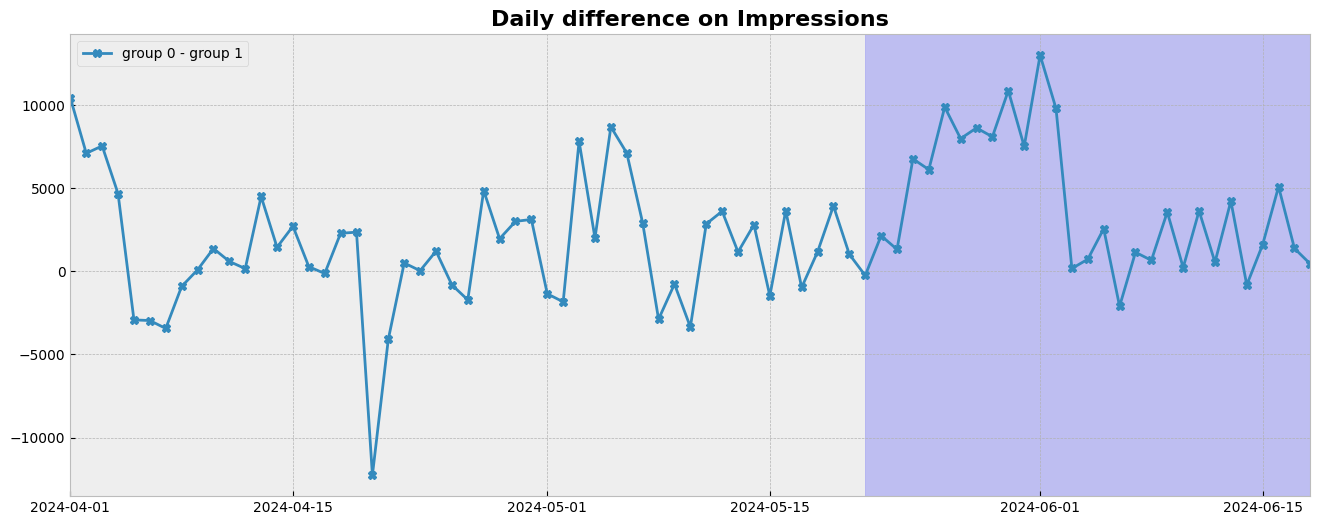

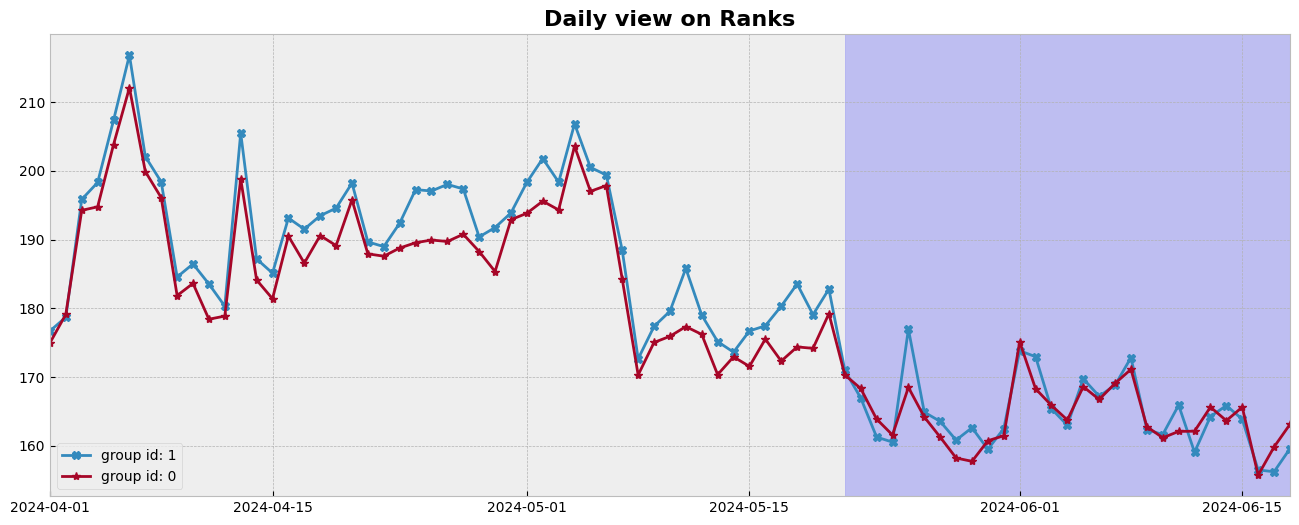

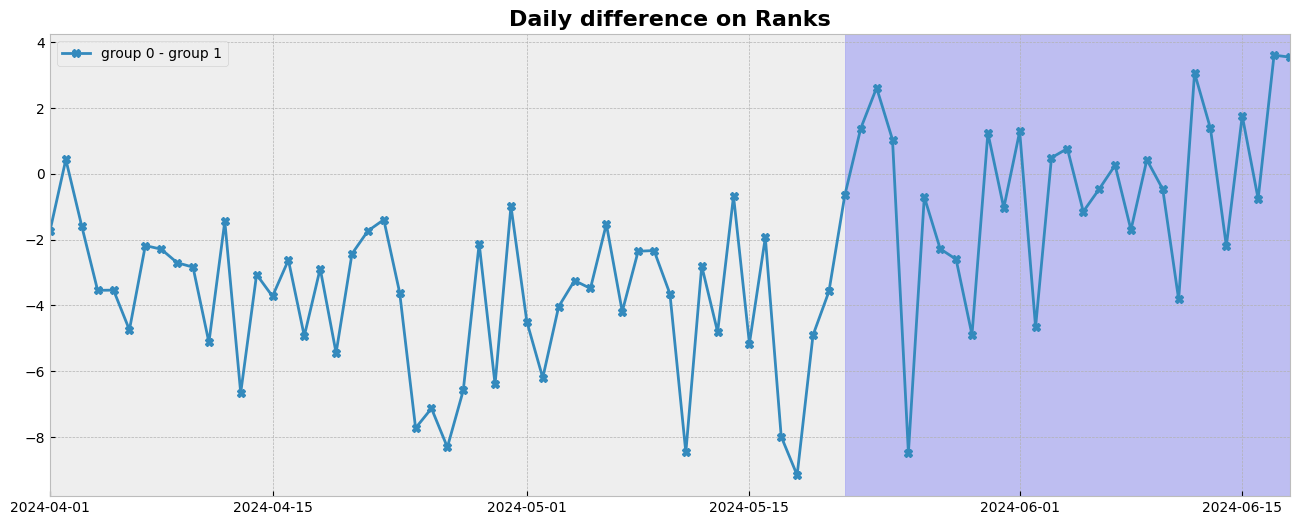

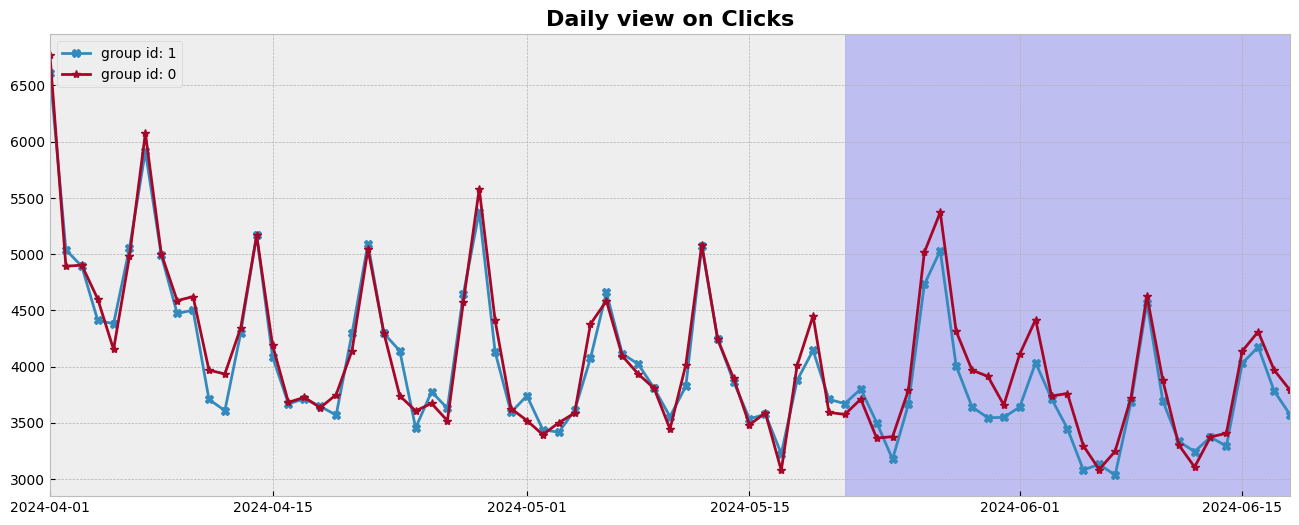

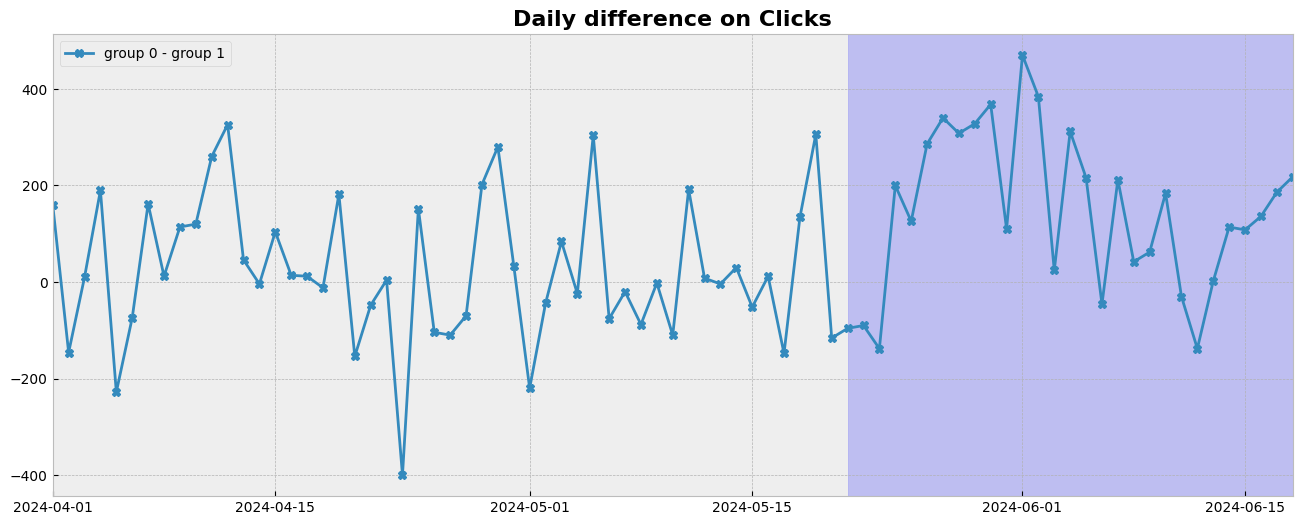

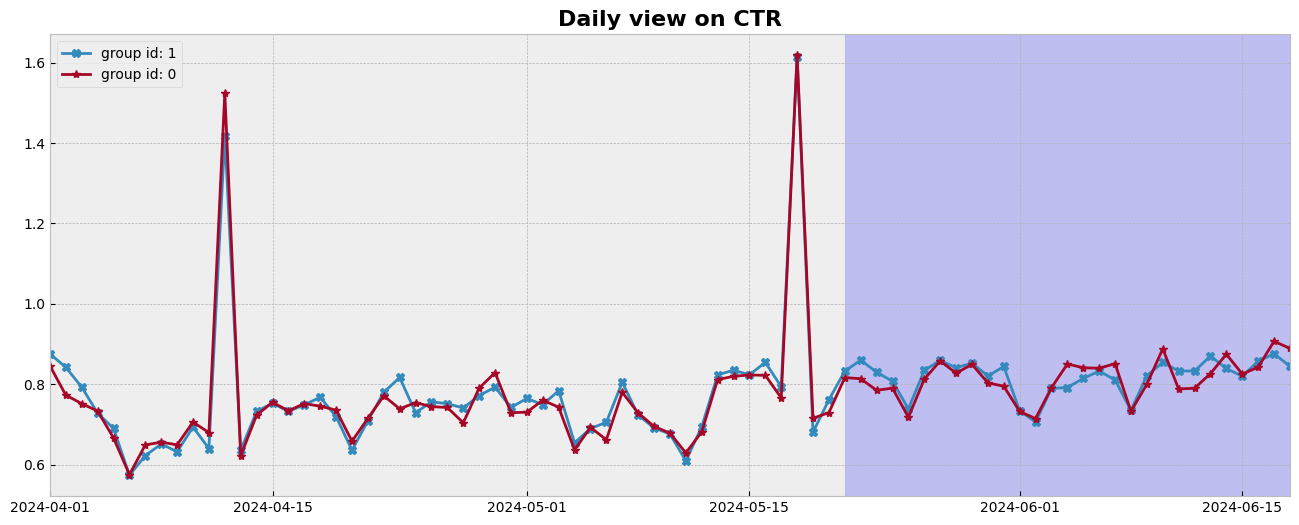

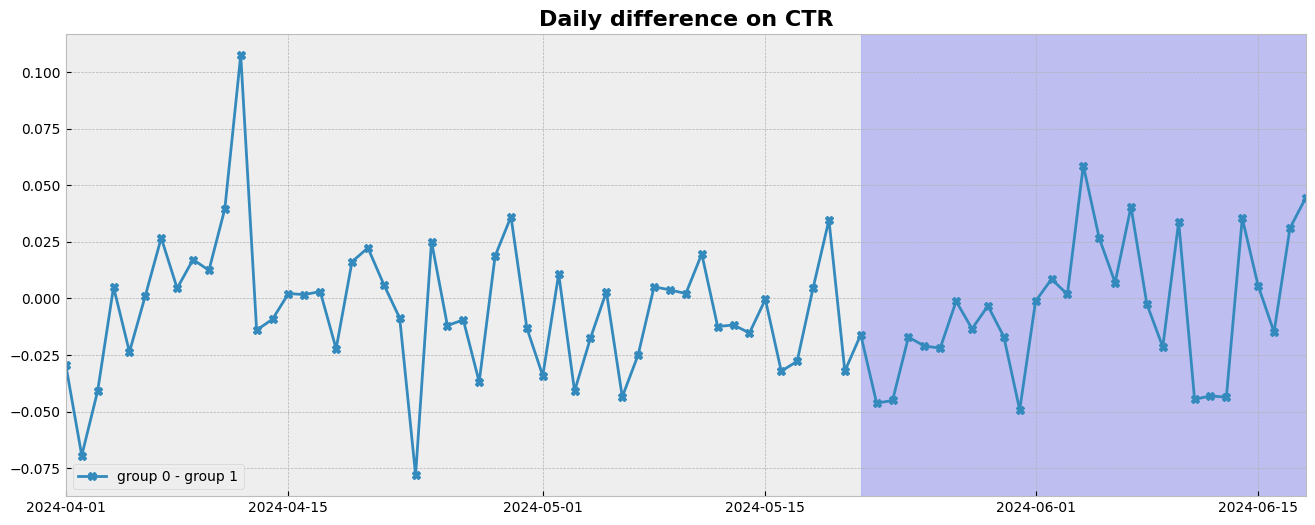

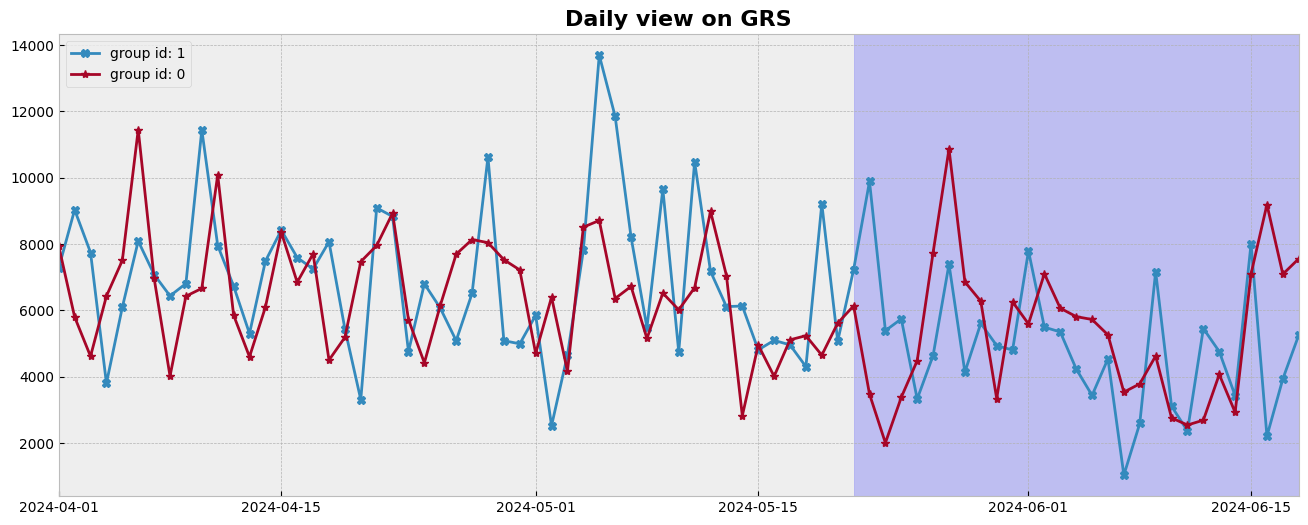

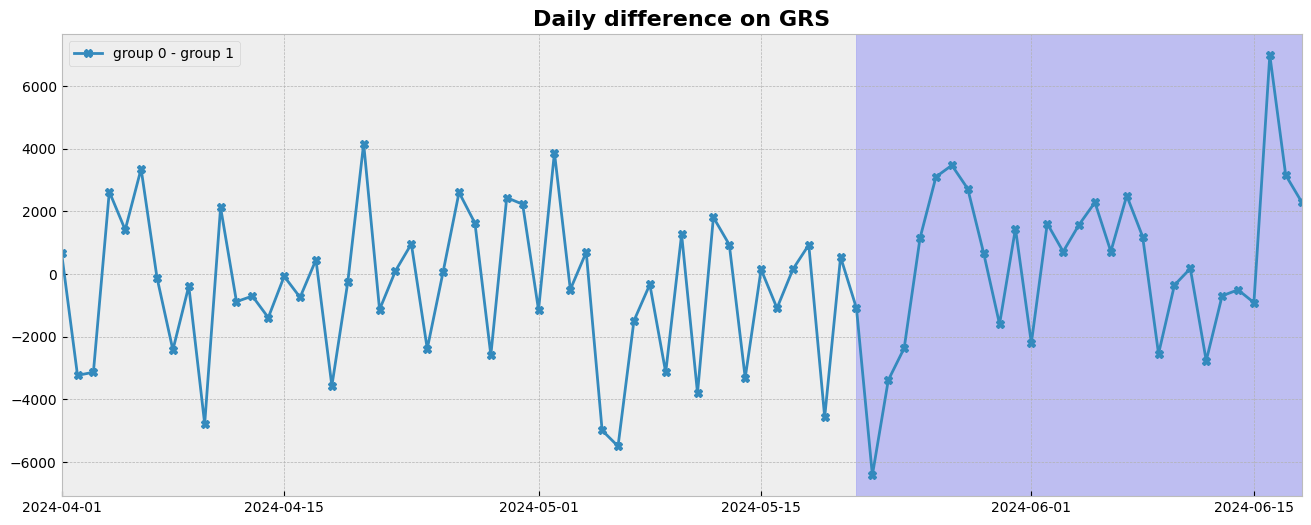

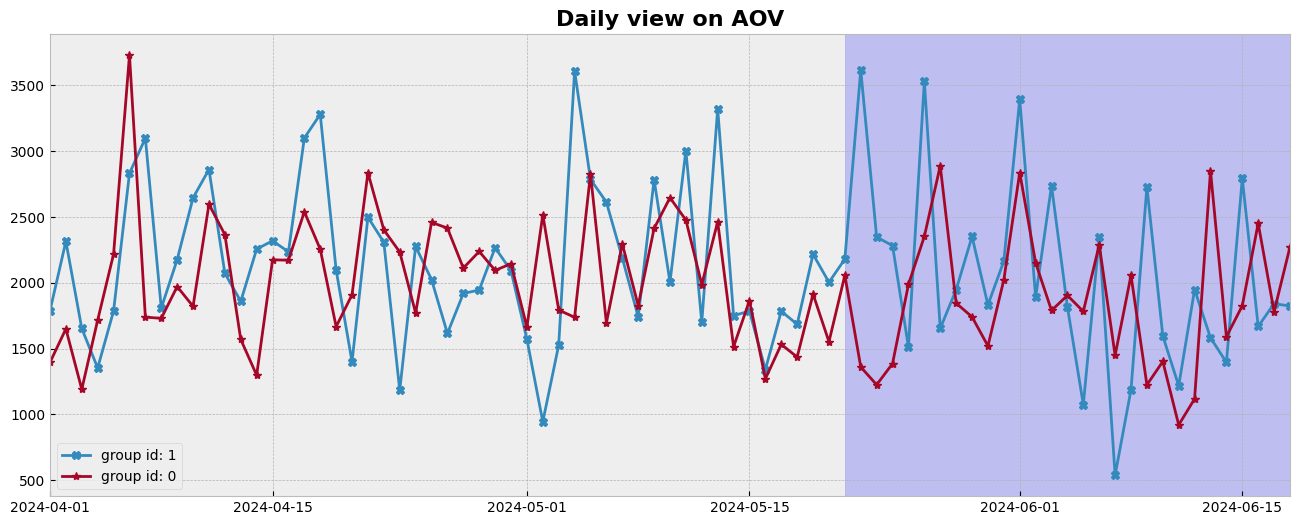

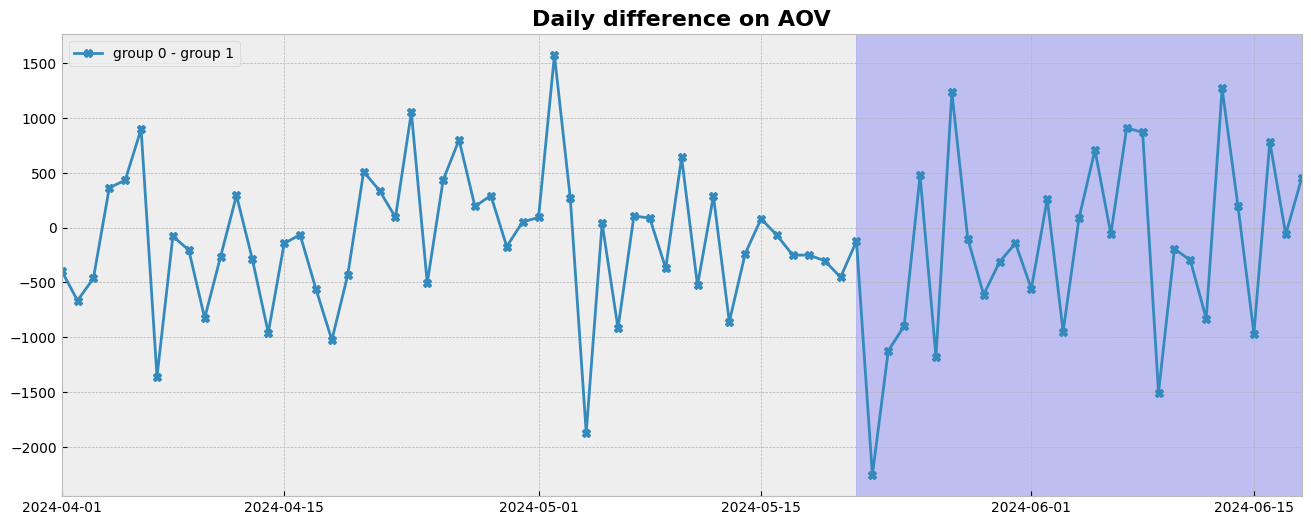

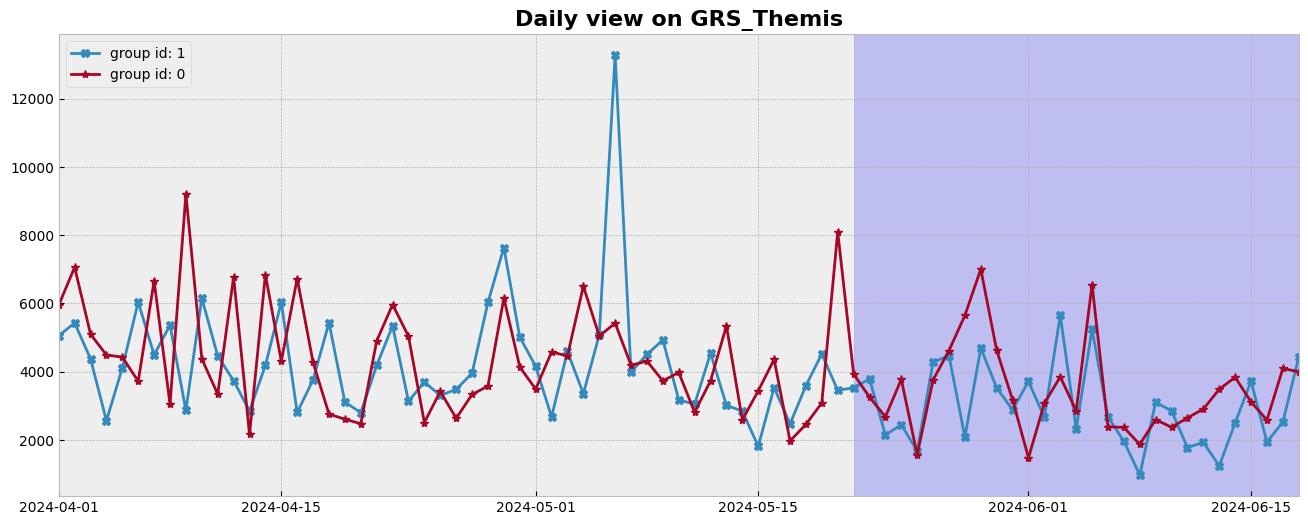

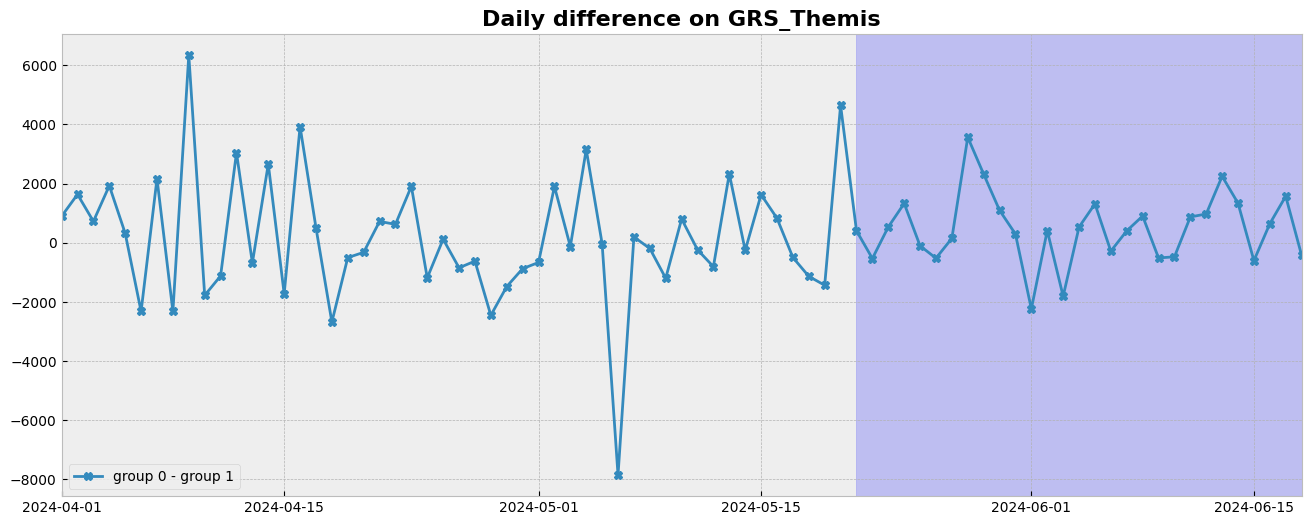

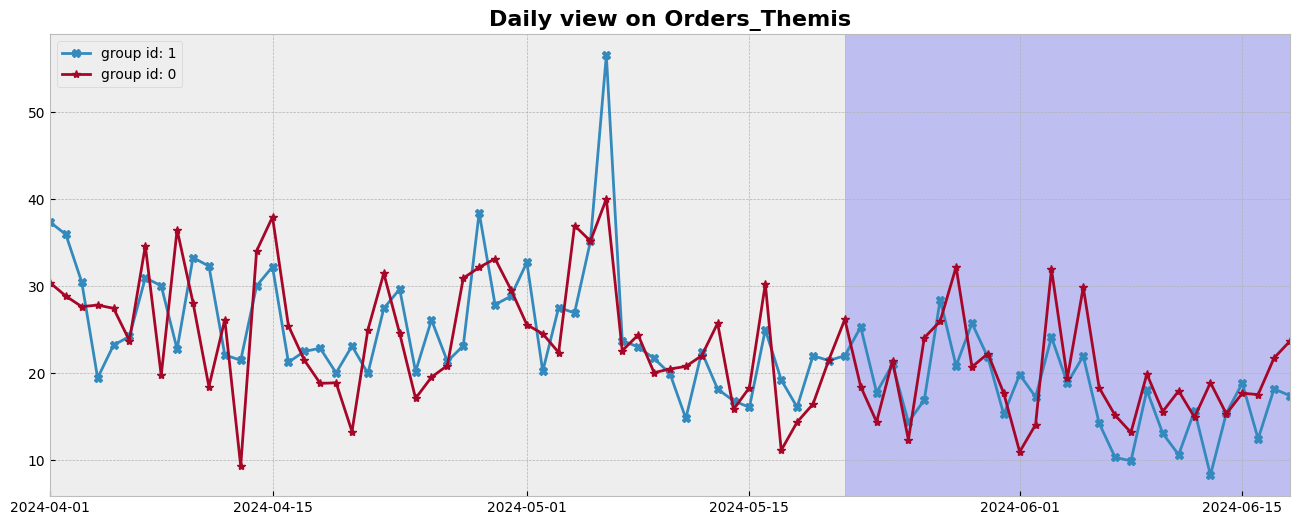

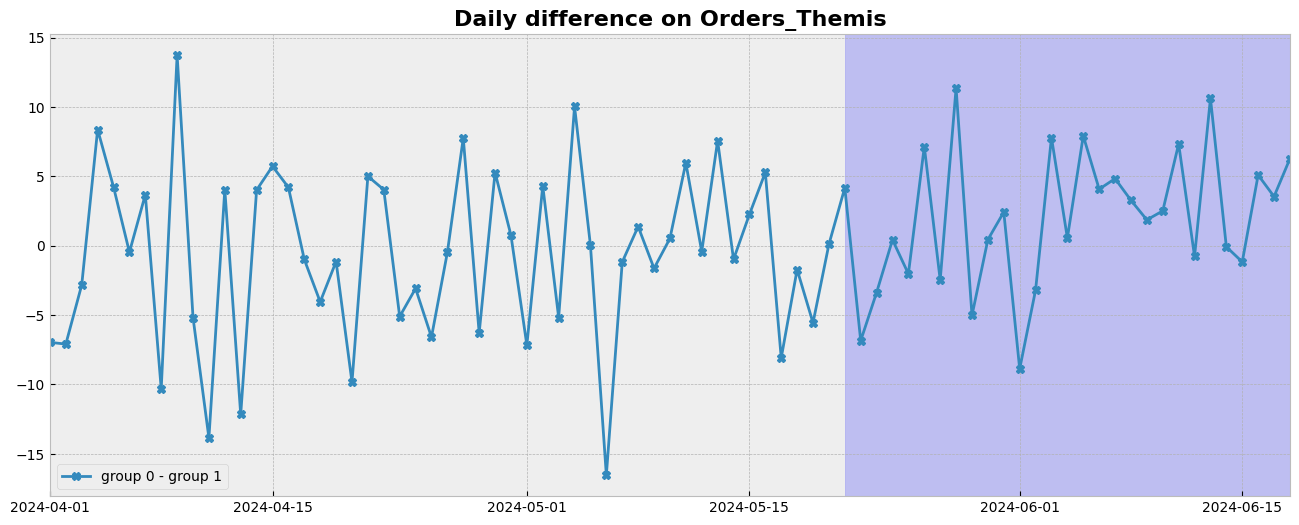

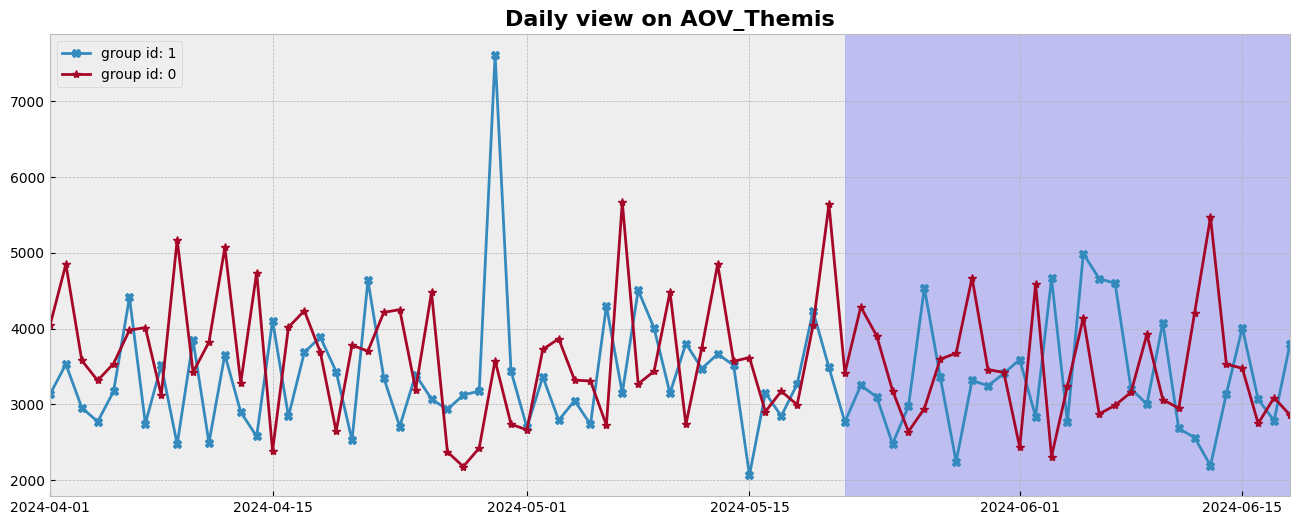

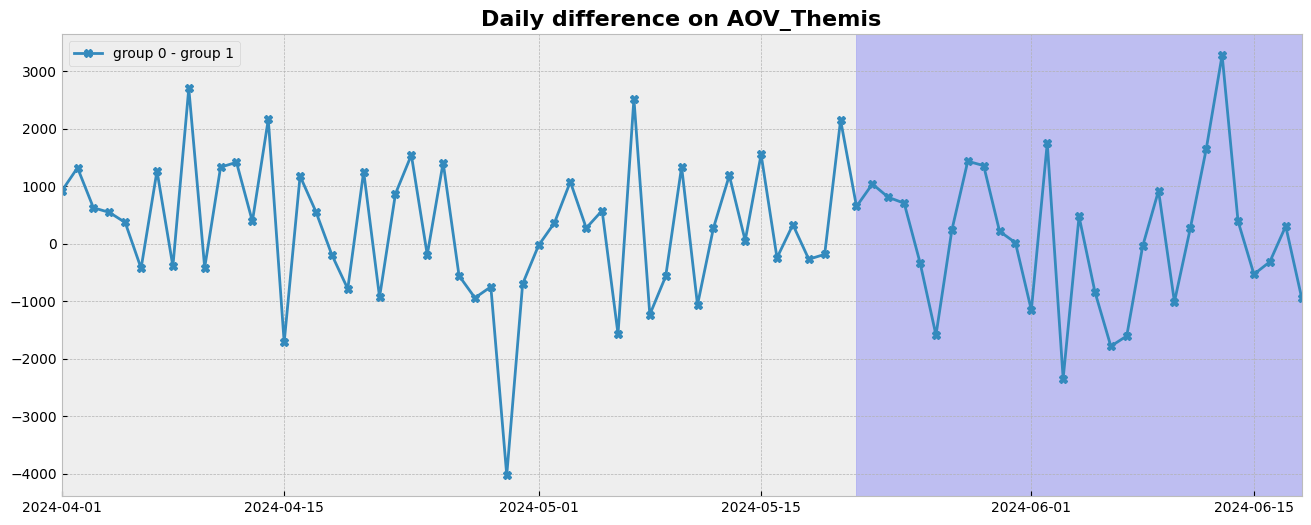

In [42]:
plot_comparisons(daily_data=measurement_df, 
                metrics = KPI_measurement_cols, 
                group_column = 'testgroup', 
                date_column = date_column_meas,
                group_ids=[1,0], 
                group_ratios=[0.5, 0.5], 
                time_range=[validation_start_date, test_end_date], 
                shade_window=[test_start_date, test_end_date], 
                include_diff=True)